# Principles of Data Science Coursework
## Airbnb listings in London: Analysis of key characteristics driving revenue

**Author: Miguel Bravo**

**Dataset used:**  
Snapshot of all Airbnb listings in London – sourced from [insideairbnb.com](http://www.insideairbnb.com).

**Analysis Objectives:**    
1.	Perform exploratory data analysis to understand structure of data and inform further analysis
2.	Select and train appropriate models to estimate a listing’s revenue relative to peers based on its characteristics.
3.	Examine most important characteristics driving revenue performance, as estimated by each model
4.	Interpret practical insights arising from these estimates on ways a host can improve their listing’s revenue performance.

## Data Preprocessing
Load data, derive target and features, perform basic feature selection

### Import modules

In [1]:
#Import modules needed for data pre-processing
import pandas as pd
import numpy as np
import scipy as sc
import string
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
import warnings
from IPython.display import Image
%matplotlib inline

### Load data

In [2]:
#Load airbnb London listings dataset:
listings = pd.read_csv('listings.csv',low_memory=False)

In [3]:
#Check shape of data (row count and column count):
listings.shape

(74153, 96)

Let's look at the different fields in the data

In [4]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
warnings.filterwarnings('ignore')
listings.head(2).T

0  \
id                                                                             9554   
listing_url                                       https://www.airbnb.com/rooms/9554   
scrape_id                                                            20181006000810   
last_scraped                                                             2018-10-06   
name                                             Cozy, 3 minutes to Piccadilly Line   
summary                           PLEASE CONTACT ME BEFORE BOOKING Homely apartm...   
space                             Hello people, This is a bright, comfortable ro...   
description                       PLEASE CONTACT ME BEFORE BOOKING Homely apartm...   
experiences_offered                                                            none   
neighborhood_overview                                           Details to follow..   
notes                                                                           NaN   
transit                                     details to follow when i get a chance..   
access                            Kitchen, small dining / smoking room (if you s...   
interaction                       Depends on what else I have on.. It is always ...   
house_rules                       If you smoke, please do so only in the little ...   
thumbnail_url                                                                   NaN   
medium_url                                                                      NaN   
picture_url                       https://a0.muscache.com/im/pictures/77912984/a...   
xl_picture_url                                                                  NaN   
host_id                                                                       31655   
host_url                                    https://www.airbnb.com/users/show/31655   
host_name                                                                       Guy   
host_since                                                               2009-08-14   
host_location                                       London, England, United Kingdom   
host_about                        Please contact me before booking! Please see d...   
host_response_time                                                   within an hour   
host_response_rate                                                             100%   
host_acceptance_rate                                                            NaN   
host_is_superhost                                                                 t   
host_thumbnail_url                https://a0.muscache.com/im/pictures/9cae5e2c-3...   
host_picture_url                  https://a0.muscache.com/im/pictures/9cae5e2c-3...   
host_neighbourhood                                                   LB of Haringey   
host_listings_count                                                               4   
host_total_listings_count                                                         4   
host_verifications                ['email', 'phone', 'manual_online', 'reviews',...   
host_has_profile_pic                                                              t   
host_identity_verified                                                            f   
street                                                       London, United Kingdom   
neighbourhood                                                        LB of Haringey   
neighbourhood_cleansed                                                     Haringey   
neighbourhood_group_cleansed                                                    NaN   
city                                                                         London   
state                                                                           NaN   
zipcode                                                                      N8 0EY   
market                                                                       London   
smart_location                                               London, United King

Target yet to be derived, fields need to be cleansed and converted to features which can be used in machine learning.

Feature engineering key principles used:
1. Capture as much raw information as possible in derived features. Only discard field if irrelevant or unworkable
2. Derive new features going beyond raw data, if considered useful for analysis

### Derive target
The target variable is a listing's monthly revenue differential from peer group average (i.e. monthly revenue relative to peers). Target needs to be derived as follows:
1. Estimate monthly revenue based on the 'San Francisco' occupancy model
2. Calculate mean monthly revenue per peer group.
3. Derive target 

**'San Francisco' occupancy model**   
Assumptions:
1. A Review Rate of 50% is used to convert reviews per month to estimated bookings per month. 
2. Average length of stay (in days) is used to convert estimated bookings to occupancy per month. This is the greater of 4.6 nights (Airbnb published LOS for London), or minimum nights stay per listing
3. Occupancy is capped at 70% as this is a reasonable number for a highly occupied "hotel"

**Derive monthly revenue**

In [5]:
#Derive estimated bookings per month (assuming review to bookings rate of 50%):
listings['bookings_per_month'] = listings['reviews_per_month']*2

#create function which chooses the greater of average length of stay or minimum nights for each listing.
def los(min_nights):
    if min_nights>4.6:
        return min_nights
    else:
        return 4.6

#derive estimated average occupancy per month
listings['occupancy_per_month'] = listings['bookings_per_month']*listings['minimum_nights'].apply(los)

#Cap occupancy per month at 70% (assuming average month duration of 365/12):
over_70_pct = (listings['occupancy_per_month']/(365/12))>0.7
listings.loc[(over_70_pct),'occupancy_per_month'] = (365/12)*0.7

#convert price to numeric
price = listings['price'].apply(lambda x: str(x).strip('$').replace(',',''))
listings['price'] = pd.to_numeric(price,errors='coerce')

#derive revenue per month based on occupancy and price
listings['revenue_per_month'] = listings['occupancy_per_month']*listings['price']

#check sample of calculate fields to ensure calculation worked correctly
listings[['reviews_per_month','bookings_per_month','minimum_nights',\
          'occupancy_per_month','price','revenue_per_month']].head(20)

reviews_per_month  bookings_per_month  minimum_nights  \
0                1.69                3.38               1   
1                0.07                0.14               2   
2                0.20                0.40               4   
3                0.14                0.28               1   
4                0.69                1.38               2   
5                3.41                6.82               2   
6                0.34                0.68               1   
7                0.13                0.26               3   
8                 NaN                 NaN               1   
9                0.40                0.80               3   
10               0.78                1.56              15   
11               0.99                1.98               3   
12               2.06                4.12               1   
13               0.96                1.92              90   
14               1.79                3.58               1   
15               0.19                0.38               4   
16               0.07                0.14               5   
17               0.66                1.32               2   
18               0.78                1.56               1   
19                NaN                 NaN               1   

    occupancy_per_month  price  revenue_per_month  
0             15.548000   35.0         544.180000  
1              0.644000   70.0          45.080000  
2              1.840000  231.0         425.040000  
3              1.288000   55.0          70.840000  
4              6.348000   51.0         323.748000  
5             21.291667  105.0        2235.625000  
6              3.128000   98.0         306.544000  
7              1.196000   35.0          41.860000  
8                   NaN   29.0                NaN  
9              3.680000  300.0        1104.000000  
10            21.291667   25.0         532.291667  
11             9.108000   90.0         819.720000  
12            18.952000   77.0        1459.304000  
13            21.291667  150.0        3193.750000  
14            16.468000   42.0         691.656000  
15             1.748000  164.0         286.672000  
16             0.700000  102.0          71.400000  
17             6.072000   49.0         297.528000  
18             7.176000   85.0         609.960000  
19                  NaN   35.0                NaN

In [6]:
#Missing values detected; perform missing value count on target:
print('missing values: ',listings['revenue_per_month'].isnull().sum())

missing values:  18651


In [7]:
#fill missing values with median - more resistant against extreme values in distribution
median_revenue = listings['revenue_per_month'].median()
listings['revenue_per_month'] = listings['revenue_per_month'].fillna(median_revenue)

#remove features used as steps in calculating target
listings.drop(['occupancy_per_month','bookings_per_month'],axis=1,inplace=True)

**Derive mean monthly revenue per peer group**    
Listings are in the same peer group if they have the same neighbourhood, room type, number of bedrooms and bathrooms.

**Neighbourhood**   

In [8]:
#decide which neighbourhood field to use
nhood_list = ['neighbourhood','neighbourhood_cleansed']

for nhood in nhood_list:
    print(nhood,':','\n',listings[nhood].unique()[0:10])
    #missing values
    print('missing:',(listings[nhood].isnull().sum()),'\n')

neighbourhood : 
 ['LB of Haringey' 'LB of Ealing' 'Covent Garden' 'LB of Islington'
 'Forest Hill' 'Notting Hill' nan 'City of Westminster' 'Fitzrovia'
 'LB of Barnet']
missing: 3962 

neighbourhood_cleansed : 
 ['Haringey' 'Ealing' 'Westminster' 'Islington' 'Lewisham'
 'Kensington and Chelsea' 'Barnet' 'Wandsworth' 'Tower Hamlets' 'Hounslow']
missing: 0 



In [9]:
#use neighbourhood cleansed - all values appear to be at borough level.
listings.drop('neighbourhood',axis=1,inplace=True)

**Room type**  

In [10]:
#missing values
print('missing:',(listings['room_type'].isnull().sum()))

#value counts
listings['room_type'].value_counts()

#values all ok - no changes needed

missing: 0


Entire home/apt    40647
Private room       32794
Shared room          712
Name: room_type, dtype: int64

**Bedrooms**  

In [11]:
#missing values
print('missing:',(listings['bedrooms'].isnull().sum()))

#value counts
print(listings['bedrooms'].value_counts())

missing: 51
1.0     47146
2.0     15133
3.0      4905
0.0      4263
4.0      1903
5.0       586
6.0       126
7.0        27
8.0         6
11.0        2
9.0         2
10.0        2
12.0        1
Name: bedrooms, dtype: int64


In [12]:
#51 missing values found - impute with median.
median_bedrooms = listings['bedrooms'].median()
listings['bedrooms'] = listings['bedrooms'].fillna(median_bedrooms)

Put number of bedrooms into buckets:

In [13]:
#define function to bucket bedrooms.
def bucket_bedrooms(bedrooms):
    if bedrooms >= 6:
        return '6+'
    else:
        return str(int(bedrooms))

#bucket bedrooms
listings['bedrooms'] = listings['bedrooms'].apply(bucket_bedrooms)

#check new groups
listings['bedrooms'].value_counts()

1     47197
2     15133
3      4905
0      4263
4      1903
5       586
6+      166
Name: bedrooms, dtype: int64

**Bathrooms**  

In [14]:
#missing values
print('missing:',(listings['bathrooms'].isnull().sum()))

#value counts
print(listings['bathrooms'].value_counts())

missing: 188
1.0     53506
2.0     10910
1.5      5098
2.5      1823
3.0      1246
3.5       394
0.5       306
4.0       231
0.0       222
4.5        67
5.0        57
10.0       26
6.0        24
8.0        16
5.5        14
7.0        12
6.5         6
14.0        2
8.5         1
10.5        1
7.5         1
11.0        1
9.0         1
Name: bathrooms, dtype: int64


In [15]:
#188 missing values found - impute with median
median_bathrooms = listings['bathrooms'].median()
listings['bathrooms'] = listings['bathrooms'].fillna(median_bathrooms)

#define function to bucket bathrooms
def bucket_bathrooms(bathrooms):
    if bathrooms==0:
        return '0'
    elif bathrooms<=1:
        return '1'
    elif bathrooms<=2:
        return '2'
    elif bathrooms<=3:
        return '3'
    else:
        return '4+'

#bucket bathrooms
listings['bathrooms'] = listings['bathrooms'].apply(bucket_bathrooms)

#check new groups
listings['bathrooms'].value_counts()

1     54000
2     16008
3      3069
4+      854
0       222
Name: bathrooms, dtype: int64

**Calculate average revenue per peer group**

In [16]:
#create dataframe which holds average monthly revenue per peer group
peer_group_revenue_means = listings.groupby(['neighbourhood_cleansed','room_type','bedrooms','bathrooms'],\
                                as_index=False)[['revenue_per_month']].mean().sort_values(\
                                by=['neighbourhood_cleansed','room_type','bedrooms','bathrooms'],\
                                ascending=[True,True,True,True]).reset_index(drop=True)
peer_group_revenue_means.rename(columns={'revenue_per_month':'mean_revenue'},inplace=True)

#show sample of 20
peer_group_revenue_means.head(20)

neighbourhood_cleansed        room_type bedrooms bathrooms  mean_revenue
0    Barking and Dagenham  Entire home/apt        0         1    295.387778
1    Barking and Dagenham  Entire home/apt        1         1    417.149103
2    Barking and Dagenham  Entire home/apt        2         1    633.239877
3    Barking and Dagenham  Entire home/apt        2         2    647.738333
4    Barking and Dagenham  Entire home/apt        2         3    553.583333
5    Barking and Dagenham  Entire home/apt        3         1    773.591667
6    Barking and Dagenham  Entire home/apt        3         2   1148.435000
7    Barking and Dagenham  Entire home/apt        4         1    553.583333
8    Barking and Dagenham  Entire home/apt        4         2    454.397667
9    Barking and Dagenham  Entire home/apt        4         3   1130.250667
10   Barking and Dagenham  Entire home/apt        5        4+   4237.041667
11   Barking and Dagenham  Entire home/apt       6+         3   1037.760000
12   Barking and Dagenham     Private room        0         1    442.548333
13   Barking and Dagenham     Private room        1         0    286.681667
14   Barking and Dagenham     Private room        1         1    398.146753
15   Barking and Dagenham     Private room        1         2    298.774333
16   Barking and Dagenham     Private room        1         3    419.621667
17   Barking and Dagenham     Private room        2         1    223.863833
18   Barking and Dagenham     Private room        3         2    553.583333
19   Barking and Dagenham      Shared room        1         1    435.146667

**Derive target variable**

In [17]:
#get tuples containing the defining features of each peer group (i.e. neighourhood, room type, bedrooms, bathrooms)
subset = peer_group_revenue_means[['neighbourhood_cleansed','room_type','bedrooms','bathrooms']]
peer_group_tuples = [tuple(x) for x in subset.values]

#create empty field to hold target
listings['revenue_var'] = np.nan

#populate target

#for each peer group
for nhood,rtype,beds,baths in peer_group_tuples:
#define truth condition to get listings in peer group
    listing_in_peer_group = ((listings['neighbourhood_cleansed']==nhood) & \
                             (listings['room_type']==rtype) & \
                             (listings['bedrooms']==beds) & \
                             (listings['bathrooms']==baths))
#define truth condition get mean of peer group
    is_listing_mean = ((peer_group_revenue_means['neighbourhood_cleansed']==nhood) & \
                        (peer_group_revenue_means['room_type']==rtype) & \
                        (peer_group_revenue_means['bedrooms']==beds) & \
                        (peer_group_revenue_means['bathrooms']==baths))
#get peer group mean
    mean = peer_group_revenue_means.loc[is_listing_mean,'mean_revenue'].values[0]
#calculate revenue variance from mean for each listing in peer group
    listings.loc[listing_in_peer_group,'revenue_var'] = \
    listings.loc[listing_in_peer_group,'revenue_per_month'] - mean

#print out any missing values in revenue variance
print('missing:',(listings['revenue_var'].isnull().sum()))

#show top 5 values for revenue variance
listings[['revenue_per_month','revenue_var']].head()

missing: 0


revenue_per_month  revenue_var
0            544.180   148.755060
1             45.080  -391.089153
2            425.040  -736.425718
3             70.840  -455.112545
4            323.748   -55.999310

**Examine target variable**    

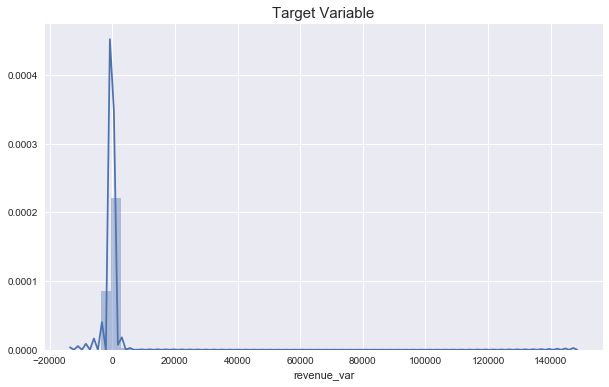

In [18]:
#examine distribution
plt.figure(figsize=(10,6))
plt.title('Target Variable',fontsize=15)
sns.distplot(listings['revenue_var'])

It has a very long right tail. Let's explore outliers.

In [19]:
#Get upper and lower limits for outliers
mean = listings['revenue_var'].mean()
std = listings['revenue_var'].std()
lower_limit = mean - 2*std
upper_limit = mean + 2*std
print('upper limit: '+str(upper_limit))
print('lower limit: '+str(lower_limit))

#check how many outliers there are
isOutlier = ((listings['revenue_var']>upper_limit)|(listings['revenue_var']<lower_limit))
print('outlier count:',(isOutlier*1).sum())

upper limit: 2473.8698047878033
lower limit: -2473.869804787805
outlier count: 1226


Let's look at descriptions of top 10 outliers.

In [20]:
isOutlier = (listings['revenue_var']>upper_limit)
listings.loc[(isOutlier),\
            ['name','summary','description',\
             'neighbourhood_cleansed','revenue_var']].sort_values(by='revenue_var',ascending=False).head(10)

name  \
45825     RK03D Large room near Kings Cross and Eurostar   
4599               Lovely Large Double Room with ensuite   
59933              Eccleston Square Hotel City King Room   
67359         Luxurious 7 Bedroom Home with Pool Chelsea   
13061                Best 3 bed/2 bath in all of London!   
50365                           Central 2 bed Apt Zone 1   
57563  STUNNING big marina apartment, Zone 1 - Superh...   
71299     Exceptional Whitehall Penthouse w/ 360° views!   
59932         Eccleston Square Hotel Signature King Room   
60176   Close to Central London flat spacious and bright   

                                                 summary  \
45825  Large room that can sleep 6 , but with the hel...   
4599   This Large Double Four Poster Bedroom with ens...   
59933                                                NaN   
67359  A beautiful family home with exceptional views...   
13061  3 bedroom, 2 bathroom, in Soho. Spacious, comf...   
50365  This charming apartment is an ideal Central Lo...   
57563  Luxury apartment in an exclusive, unique area ...   
71299  This is one of London's most impressive and un...   
59932                                                NaN   
60176  Spacious comfortable bright apartment 5 minute...   

                                             description  \
45825  Large room that can sleep 6 , but with the hel...   
4599   This Large Double Four Poster Bedroom with ens...   
59933  24 hours reception team that can assist guests...   
67359  A beautiful family home with exceptional views...   
13061  3 bedroom, 2 bathroom, in Soho. Spacious, comf...   
50365  This charming apartment is an ideal Central Lo...   
57563  Luxury apartment in an exclusive, unique area ...   
71299  This is one of London's most impressive and un...   
59932  24 hours reception team that can assist guests...   
60176  Spacious comfortable bright apartment 5 minute...   

       neighbourhood_cleansed    revenue_var  
45825                  Camden  148270.470012  
4599   Hammersmith and Fulham  139004.507526  
59933             Westminster   73703.035335  
67359  Kensington and Chelsea   49982.327667  
13061                  Camden   42627.245693  
50365                  Camden   36041.652749  
57563          City of London   27555.979764  
71299             Westminster   25131.199545  
59932             Westminster   23108.095335  
60176               Islington   20447.753422

They look like premium listings and are located in central London. Let's look at key distributions

Text(0.5,1,'reviews_per_month')

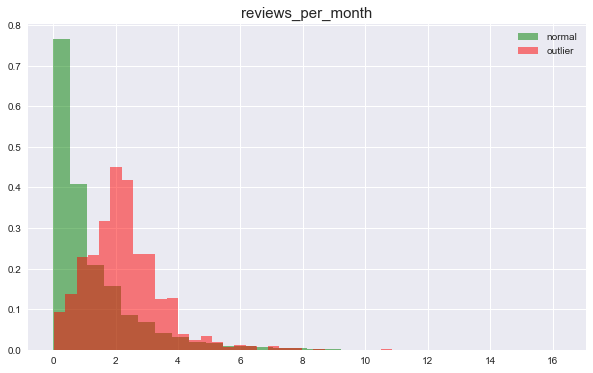

In [21]:
#reviews per month 
plt.figure(figsize=(10,6))
plt.hist(listings[isOutlier==False]['reviews_per_month'].dropna(),density=True,color='green',label='normal',\
         bins=30,alpha=0.5)
plt.hist(listings[isOutlier]['reviews_per_month'].dropna(),density=True,color='red',label='outlier',\
         bins=30,alpha=0.5)
plt.legend()
plt.title('reviews_per_month',fontsize=15)

Text(0.5,1,'price')

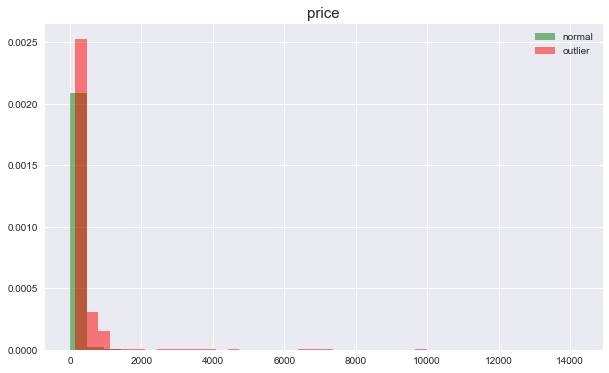

In [22]:
#price
plt.figure(figsize=(10,6))
plt.hist(listings[isOutlier==False]['price'].dropna(),density=True,color='green',label='normal',\
         bins=30,alpha=0.5)
plt.hist(listings[isOutlier]['price'].dropna(),density=True,color='red',label='outlier',\
         bins=30,alpha=0.5)
plt.legend()
plt.title('price',fontsize=15)

Text(0.5,1,'review_scores_rating')

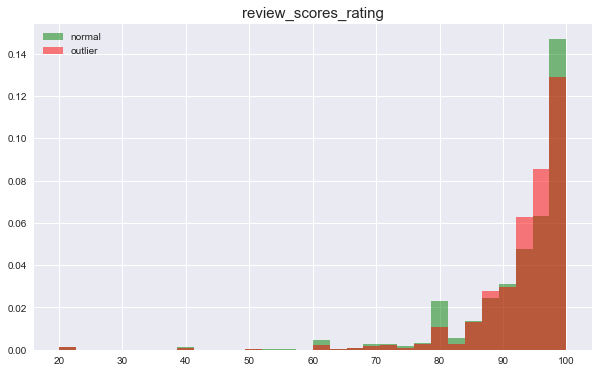

In [23]:
#review scores rating
plt.figure(figsize=(10,6))
plt.hist(listings[isOutlier==False]['review_scores_rating'].dropna(),density=True,color='green',label='normal',\
         bins=30,alpha=0.5)
plt.hist(listings[isOutlier]['review_scores_rating'].dropna(),density=True,color='red',label='outlier',\
         bins=30,alpha=0.5)
plt.legend()
plt.title('review_scores_rating',fontsize=15)

Outliers have higher price than norm - helps explain why they're outliers.

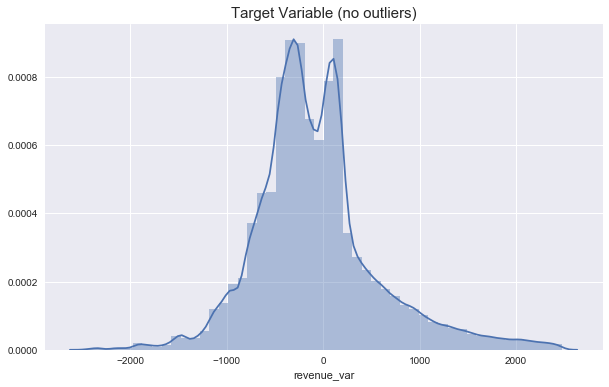

In [24]:
#check distribution of target without outliers
isOutlier = ((listings['revenue_var']>upper_limit)|(listings['revenue_var']<lower_limit))
plt.figure(figsize=(10,6))
plt.title('Target Variable (no outliers)',fontsize=15)
sns.distplot(listings[isOutlier==False]['revenue_var'])

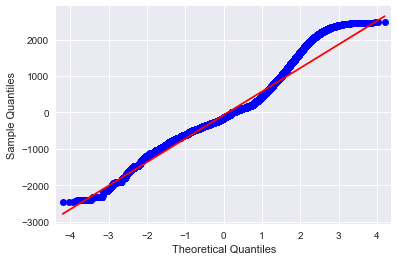

In [25]:
#Q-Q plot of target
qqplot(listings.loc[(isOutlier==False),'revenue_var'].dropna(), line='s')
plt.show()

Target looks pretty normally distributed without outliers - remove outliers

In [26]:
listings = listings[isOutlier==0].reset_index(drop=True)

Remove all fields used to define peer groups - reflected in target

In [27]:
listings.drop(['revenue_per_month','neighbourhood_cleansed','room_type','bedrooms',\
               'bathrooms',],axis=1,inplace=True)

### Remove irrelevant fields in data

**Remove ID/URL fields**

In [28]:
del_list = ['id','listing_url','scrape_id','thumbnail_url','medium_url','picture_url','xl_picture_url','host_id',        
            'host_url','host_thumbnail_url','host_picture_url','calendar_updated']

listings.drop(del_list,axis=1,inplace=True)

**Remove free text fields**

In [29]:
del_list = ['name','summary','space','description','neighborhood_overview','notes','transit','access','interaction',
           'house_rules','host_about']

listings.drop(del_list,axis=1,inplace=True)

**Remove fields with >50% missing values**

In [30]:
#get variables with missing values, along with missing value counts and percentages
missing_values = pd.DataFrame(listings.isnull().sum().sort_values(ascending=False)).reset_index()
missing_values['missing_percentage'] = missing_values[0]/listings.shape[0]*100
missing_values.columns = ['variable','missing_count','missing_percentage']
#just look at variables containing >50% missing values
missing_values[missing_values['missing_percentage']>50].reset_index(drop=True)

variable  missing_count  missing_percentage
0          host_acceptance_rate          72927          100.000000
1            jurisdiction_names          72927          100.000000
2  neighbourhood_group_cleansed          72927          100.000000
3                       license          72778           99.795686
4                   square_feet          72459           99.358262
5                 monthly_price          66830           91.639585
6                  weekly_price          64429           88.347251

In [31]:
#fields pretty much completely empty - remove them
del_list = list(missing_values.loc[(missing_values['missing_percentage']>50),'variable'])

listings.drop(del_list,axis=1,inplace=True)

**Remove redundant/repeated fields**

In [32]:
#location fields not needed - location information captured in peer groupings used to define target
del_list = ['street','city','state','zipcode','market','is_location_exact','smart_location','country_code',
            'country','latitude','longitude']

listings.drop(del_list,axis=1,inplace=True)

#remove host verifications field - key info is captured in host identity verified
del_list = ['host_verifications']

listings.drop(del_list,axis=1,inplace=True)

Host Listings count is repeated 3 times in the data. Decide which one to use.

In [33]:
#host listings count repeated 3 times. Check missing value counts
print('missing value counts:','\n',\
      listings[['host_listings_count','host_total_listings_count','calculated_host_listings_count']].isnull().sum())

missing value counts: 
 host_listings_count               34
host_total_listings_count         34
calculated_host_listings_count     0
dtype: int64


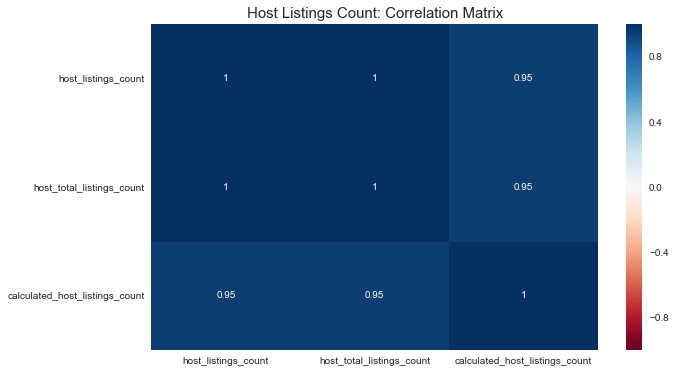

In [34]:
#check correlations
plt.figure(figsize=(10,6))
plt.title('Host Listings Count: Correlation Matrix',fontsize=15)
sns.heatmap(listings[['host_listings_count','host_total_listings_count','calculated_host_listings_count']].corr(),\
           vmin=-1, vmax=1,annot=True,cmap='RdBu')

In [35]:
#3 fields highly correlated (i.e. pretty much identical). Calculated host count has no nan's - keep this one
listings.drop(['host_total_listings_count','host_listings_count'],axis=1,inplace=True)

### Process Date fields

In [36]:
#Derive time as host (days) variable
listings['days_as_host'] = (pd.to_datetime(listings['last_scraped']) - 
                            pd.to_datetime(listings['host_since'])).dt.days

#derive days since first review of listing - proxy for how long listing has been on airbnb
listings['days_since_first_review'] = (pd.to_datetime(listings['last_scraped']) - 
                                       pd.to_datetime(listings['first_review'])).dt.days

#derive days from becoming host to getting first review
listings['days_from_host_to_first_review'] = (pd.to_datetime(listings['first_review']) - 
                                       pd.to_datetime(listings['host_since'])).dt.days

#derive days since last review of listing
listings['days_since_last_review'] = (pd.to_datetime(listings['last_scraped']) - 
                                       pd.to_datetime(listings['last_review'])).dt.days

#remove date fields - no longer needed
listings.drop(['host_since','first_review','last_review','last_scraped','calendar_last_scraped'],axis=1,inplace=True)

### Set variables to numeric

In [37]:
#extra_people
extra_people = listings['extra_people'].apply(lambda x: str(x).strip('$').replace(',',''))
listings['extra_people'] = pd.to_numeric(extra_people,errors='coerce')

#cleaning_fee
cleaning_fee = listings['cleaning_fee'].apply(lambda x: str(x).strip('$').replace(',',''))
listings['cleaning_fee'] = pd.to_numeric(cleaning_fee,errors='coerce')

#security_deposit
security_deposit = listings['security_deposit'].apply(lambda x: str(x).strip('$').replace(',',''))
listings['security_deposit'] = pd.to_numeric(security_deposit,errors='coerce')

#host_response_rate
host_response_rate = listings['host_response_rate'].apply(lambda x: str(x).strip('%').replace(',',''))
listings['host_response_rate'] = pd.to_numeric(host_response_rate,errors='coerce')

### Turn indicator flags into boolean features (0's and 1's)

In [38]:
#get indicator variable headers
variables = list(listings.columns)
indicatorVariables = []
for variable in variables:
    is_ind = (sorted(list(listings[variable].fillna('f').unique()))==['f','t'])|\
             (sorted(list(listings[variable].fillna('t').unique()))==['t'])|\
             (sorted(list(listings[variable].fillna('f').unique()))==['f'])\
              if listings[variable].dtypes=='object' else False
    if is_ind:
        indicatorVariables.append(variable)

#convert indicator variables to numeric 0/1
for variable in indicatorVariables:
    listings.loc[(listings[variable]=='t'),variable] = 1
    listings.loc[(listings[variable]=='f'),variable] = 0
    listings[variable] = pd.to_numeric(listings[variable],errors='coerce')

### Process categorical text fields

**Property Type**   

Text(0.5,1,'property_type count')

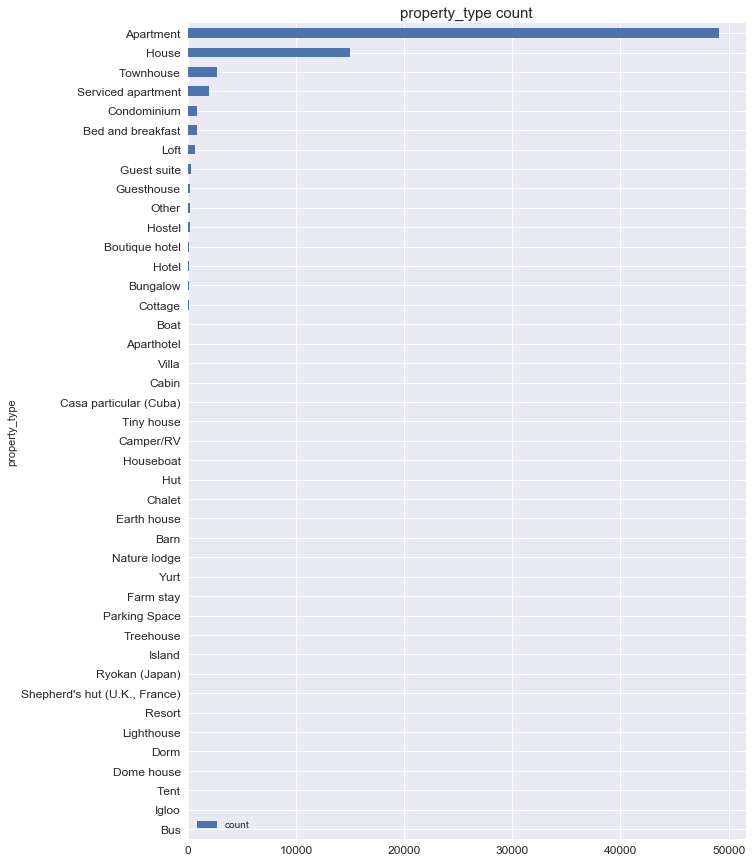

In [39]:
#check value counts
property_types = pd.DataFrame(listings['property_type'].value_counts()).reset_index()

property_types.rename(
    columns={'index':'property_type','property_type':'count'},inplace=True)

fig = property_types.sort_values(by='count',ascending=True).plot.barh(x='property_type',figsize=(10,15),fontsize=12)
plt.title('property_type count',fontsize=15)

Text(0.5,1,'property_type count')

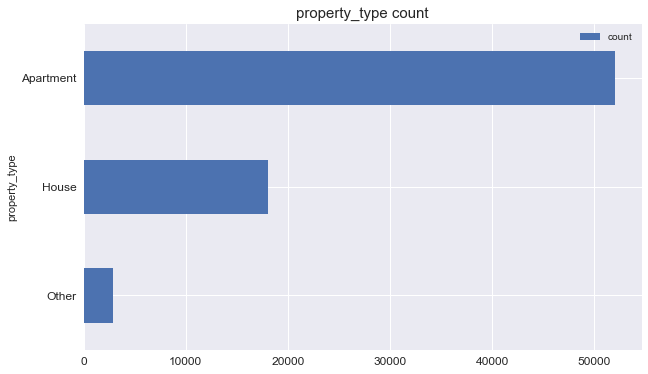

In [40]:
#put into new groups

#define function to do regrouping
def prop_regroup(prop):
    if prop in ['House','Townhouse','Bungalow','Cottage','Villa','Cabin','Casa particular (Cuba)',
                'Tiny house','Hut','Chalet','Earth house','Treehouse','Dome house','Nature lodge']:
        return 'House'
    elif prop in ['Apartment','Serviced apartment','Condominium','Aparthotel']:
        return 'Apartment'
    else:
        return 'Other'

#regroup
listings['property_type'] = listings['property_type'].apply(prop_regroup)

#check new property type classes
property_types = pd.DataFrame(listings['property_type'].value_counts()).reset_index()

property_types.rename(
    columns={'index':'property_type','property_type':'count'},inplace=True)

property_types.sort_values(by='count',ascending=True).plot.barh(x='property_type',figsize=(10,6),fontsize=12)
plt.title('property_type count',fontsize=15)

**Host Response Time**

Text(0.5,1,'host_response_time count')

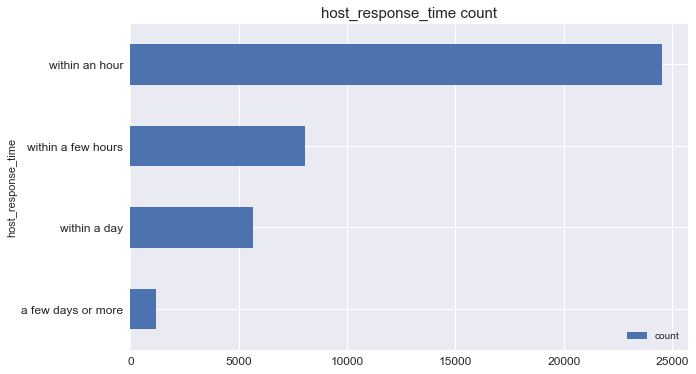

In [41]:
#check value counts
host_response_time = pd.DataFrame(listings['host_response_time'].value_counts()).reset_index()

host_response_time.rename(
    columns={'index':'host_response_time','host_response_time':'count'},inplace=True)

host_response_time.sort_values(by='count',ascending=True).plot.barh(x='host_response_time',figsize=(10,6),fontsize=12)
plt.title('host_response_time count',fontsize=15)

#categories are simple enough - leave as is

**Bed Type**

Text(0.5,1,'bed_type count')

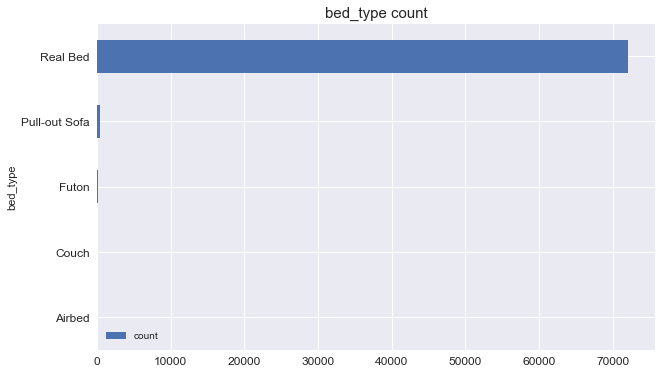

In [42]:
#check value counts
bed_type = pd.DataFrame(listings['bed_type'].value_counts()).reset_index()

bed_type.rename(
    columns={'index':'bed_type','bed_type':'count'},inplace=True)

bed_type.sort_values(by='count',ascending=True).plot.barh(x='bed_type',figsize=(10,6),fontsize=12)
plt.title('bed_type count',fontsize=15)

Text(0.5,1,'bed_type count')

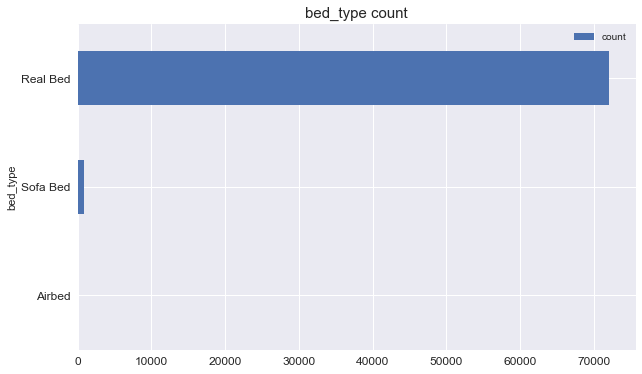

In [43]:
#put into new groups

#define mapping function to regroup categories
def bed_regroup(prop):
    if prop in ['Pull-out Sofa','Futon','Couch']:
        return 'Sofa Bed'
    else:
        return prop

#regroup categories
listings['bed_type'] = listings['bed_type'].apply(bed_regroup)

#check new categories
bed_type = pd.DataFrame(listings['bed_type'].value_counts()).reset_index()

bed_type.rename(
    columns={'index':'bed_type','bed_type':'count'},inplace=True)

bed_type.sort_values(by='count',ascending=True).plot.barh(x='bed_type',figsize=(10,6),fontsize=12)
plt.title('bed_type count',fontsize=15)

**Cancellation Policy**

Text(0.5,1,'cancellation_policy count')

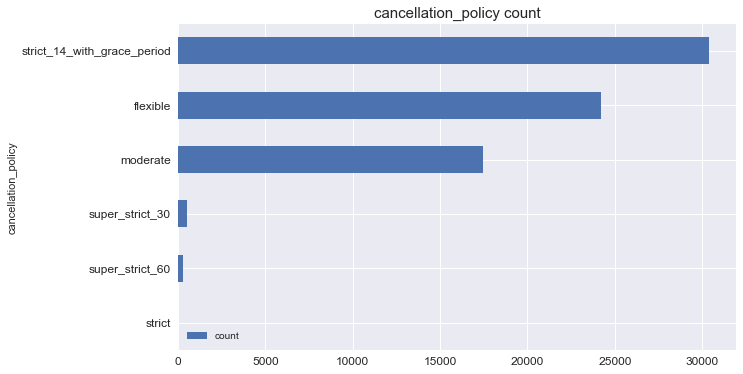

In [44]:
#check value counts
cancellation_policy = pd.DataFrame(listings['cancellation_policy'].value_counts()).reset_index()

cancellation_policy.rename(
    columns={'index':'cancellation_policy','cancellation_policy':'count'},inplace=True)

cancellation_policy.sort_values(by='count',ascending=True).plot.barh(x='cancellation_policy',figsize=(10,6),\
                                                                                             fontsize=12)
plt.title('cancellation_policy count',fontsize=15)

Text(0.5,1,'cancellation_policy count')

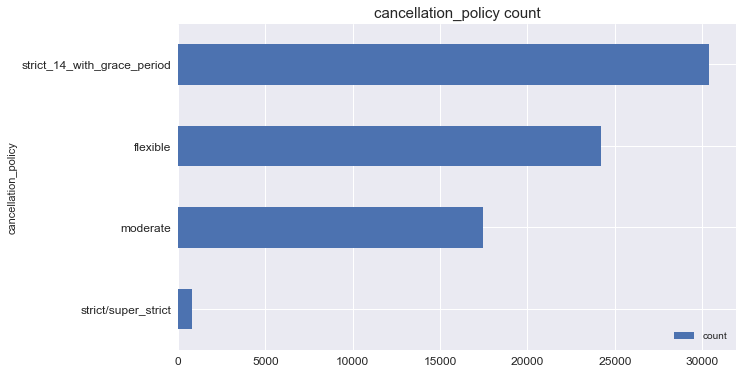

In [45]:
#put into new groups

#define mapping function to group together classes based on descriptions
def c_policy_regroup(prop):
    if prop in ['super_strict_30','super_strict_60','strict']:
        return 'strict/super_strict'
    else:
        return prop

#regroup cancellation policy classes
listings['cancellation_policy'] = listings['cancellation_policy'].apply(c_policy_regroup)

#check values again
cancellation_policy = pd.DataFrame(listings['cancellation_policy'].value_counts()).reset_index()

cancellation_policy.rename(
    columns={'index':'cancellation_policy','cancellation_policy':'count'},inplace=True)

cancellation_policy.sort_values(by='count',ascending=True).plot.barh(x='cancellation_policy',figsize=(10,6),\
                                                                     fontsize=12)
plt.title('cancellation_policy count',fontsize=15)

**Convert categorical values into boolean features (1's and 0's)**  

In [46]:
#turn categorical fields into boolean features (1's and 0's)
categorical = ['host_response_time','property_type','bed_type','cancellation_policy','experiences_offered']

dummy_vars = pd.DataFrame([])

for col in categorical:
    
    df = pd.get_dummies(listings[col])
    
    L = list(df.columns)
    Lappend = [col + "_" + s.lower().replace(' ','_') for s in L ]
    
    
    df.columns = Lappend
    
    #df = df.drop(df.columns[0],axis = 1)
    
    dummy_vars = pd.concat([dummy_vars,df],axis=1)
    
#append dummy (boolean) features to main dataset
listings = listings.join(dummy_vars)

#delete original categorical fields
categorical = ['host_response_time','property_type','bed_type','cancellation_policy','experiences_offered']
listings.drop(categorical,axis=1,inplace=True)

### Process Host fields

**Host name**  

In [47]:
#host_name -> convert to host_name_included flag (1's and 0's)
listings['host_name_included'] = (listings['host_name'].isnull()==False)*1

#drop host_name
del_list = ['host_name']
listings.drop(del_list,axis=1,inplace=True)

**Host Location**  

In [48]:
#check values
print(listings['host_location'].unique())

['London, England, United Kingdom' 'Vancouver, British Columbia, Canada'
 'Notting Hill ish London UK' ..., 'Cranbrook, England, United Kingdom'
 'Oxted, England, United Kingdom' 'USA']


In [49]:
#mish mash of different geography levels making it unworkable - remove
listings.drop('host_location',axis=1,inplace=True)

**Host Neighbourhood**   

In [50]:
#check sample of values
print(listings['host_neighbourhood'].unique()[:20])

['LB of Haringey' 'LB of Ealing' 'Covent Garden' 'LB of Islington'
 'Forest Hill' 'Notting Hill' 'Kensington' 'City of Westminster'
 'Fitzrovia' 'LB of Barnet' 'Canonbury' 'Battersea' 'Earlsfield'
 'Limehouse' 'Acton' 'Southwark' nan 'Wimbledon' 'LB of Hackney'
 'Stratford']


In [51]:
#mish mash of different geography levels, making it unworkable - remove
listings.drop('host_neighbourhood',axis=1,inplace=True)

### Process Amenities field

**Get distinct list of amenities across all listings:**

In [52]:
#get distinct list of all amenities categories in the data
amenities_all = []
for i in range(listings.shape[0]):
    amenities = listings.loc[i,'amenities'].translate(
        str.maketrans('','',
                      string.punctuation.replace(
                          '_','').replace(',','').replace('-','').replace('/',''))).lower().split(',')
    for amenity in amenities:
        amenities_all.append(amenity)
    amenities_all = list(set(amenities_all))
    
#clean up amenities list
amenities_all.remove('')
amenities_all = [w.lstrip(' ') for w in amenities_all]

#check number of distinct amenities
print('amenities count:',(len(amenities_all)))

amenities count: 186


**Calculate correlation of each indicator with target**   
Too many indicators - use correlation as a way of picking most predictive ones.

In [53]:
#turn amenities into indicator variables
amenities_df = pd.DataFrame(listings['amenities'].copy())
for amenity in amenities_all:
    amenities_df['amenities_'+amenity.replace(' ','_')] = \
    amenities_df['amenities'].apply(lambda x: amenity in x.lower())*1

#add target to amenities indicator features to calculate correlation
amenities_df['revenue_var_positive'] = (listings['revenue_var']>0)*1

#drop amenities text field
amenities_df.drop(['amenities'],axis=1,inplace=True)

Calculate correlation of each amenity indicator with the target:

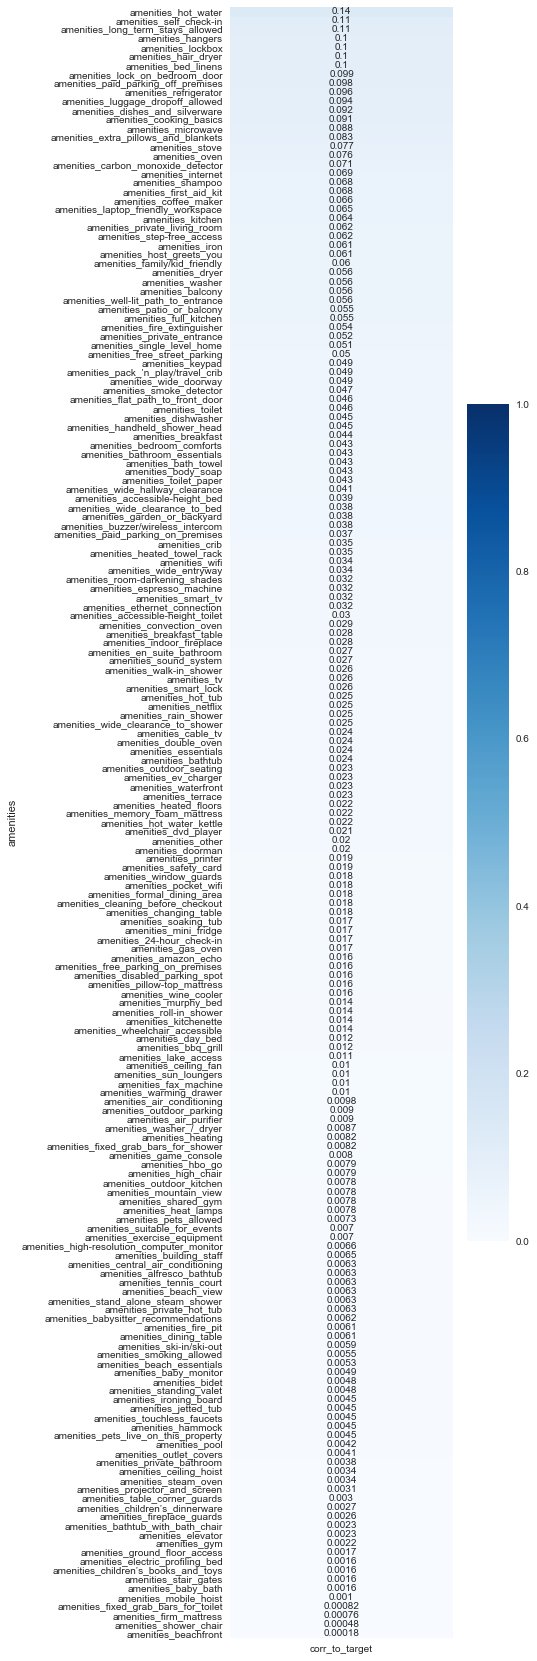

In [54]:
#calculate correlation of amenities indicators w.r.t to target indicator
amenities_to_target_corr = amenities_df.corr()['revenue_var_positive'].sort_values(ascending=False).reset_index()

#rename columns
amenities_to_target_corr.rename(
    columns={'index':'amenities','revenue_var_positive':'corr_to_target'},inplace=True)

#drop amenities with nan correlation
amenities_to_target_corr = amenities_to_target_corr.dropna()

#make correlation absolute (to take into account high negative correlation)
amenities_to_target_corr['corr_to_target'] = \
abs(amenities_to_target_corr['corr_to_target'])

#remove the target from the correlation table
amenities_to_target_corr = \
amenities_to_target_corr[amenities_to_target_corr['amenities']!='revenue_var_positive'].reset_index(drop=True)

#order amenities based on absolute correlation with target
amenities_to_target_corr = \
amenities_to_target_corr.sort_values(by='corr_to_target',ascending=False).reset_index(drop=True)

#show heat map of correlations with target
fig = plt.figure(figsize=(5,30))
sns.heatmap(amenities_to_target_corr.set_index('amenities'),annot=True,vmin=0,vmax=1,cmap='Blues')

None of the amenities are strongly correlated with the target. Regroup to remove duplicates - check effect on correlations

In [55]:
#function to regroup amenities
def amenities_regroup(amenity):
    if amenity in ['central air conditioning','air conditioning']:
        return 'air conditioning'
    elif amenity in ['patio or balcony','balcony']:
        return 'balcony'
    elif amenity in ['coffee maker','espresso machine']:
        return 'coffee maker'
    elif amenity in ['pack ’n play/travel crib','crib']:
        return 'crib'
    elif amenity in ['smoke detector','carbon monoxide detector']:
        return 'gas detector'
    elif amenity in ['gym','shared gym']:
        return 'gym'
    elif amenity in ['private hot tub','hot tub']:
        return 'hot tub'
    elif amenity in ['translation missing enhosting_amenity_50','translation missing enhosting_amenity_49']:
        return 'other'
    elif amenity in ['oven','convection oven','steam oven','gas oven','double oven']:
        return 'oven'
    elif amenity in ['free parking on premises','paid parking on premises','free street parking','outdoor parking',\
                     'disabled parking spot','paid parking off premises']:
        return 'parking'
    elif amenity in ['dogs','other pets','cats','pets live on this property']:
        return 'pets'
    elif amenity in ['en suite bathroom','private bathroom']:
        return 'private bathroom'
    elif amenity in ['accessible-height toilet','toilet']:
        return 'toilet'
    elif amenity in ['cable tv','tv','smart tv']:
        return 'tv'
    elif amenity in ['pocket wifi','wifi']:
        return 'wifi'
    else:
        return amenity

#function to redefine amenities field in data based on new groupings
def amenities_new(amenities):
    amenities_list = amenities.translate(str.maketrans('','',string.punctuation.replace('_','').\
                replace(',','').replace('-','').replace('/',''))).lower().split(',')

    amenities_regrouped = []
    for amenity in amenities_list:
        amenities_regrouped.append(amenities_regroup(amenity))
    amenities_regrouped = list(set(amenities_regrouped))

    return(amenities_regrouped)

In [56]:
#create amenities field with new groupings
listings['amenities_new'] = listings['amenities'].apply(amenities_new)

#create list of amenities with new groupings
amenities_all_regrouped = []
for amenity in amenities_all:
    amenities_all_regrouped.append(amenities_regroup(amenity))
amenities_all_regrouped = list(set(amenities_all_regrouped))

#check count of new amenities
print('amenities count:',len(amenities_all_regrouped))

amenities count: 160


In [57]:
#turn amenities into indicator variables (using new groups)
amenities_df = pd.DataFrame(listings['amenities_new'].copy())
for amenity in amenities_all_regrouped:
    amenities_df['amenities_'+amenity.replace(' ','_')] = \
    amenities_df['amenities_new'].apply(lambda x: amenity in x)*1

#add target to amenities indicator features to calculate correlation
amenities_df['revenue_var_positive'] = (listings['revenue_var']>0)*1

#drop amenities text field
amenities_df.drop(['amenities_new'],axis=1,inplace=True)

Calculate correlation w.r.t target (as before):

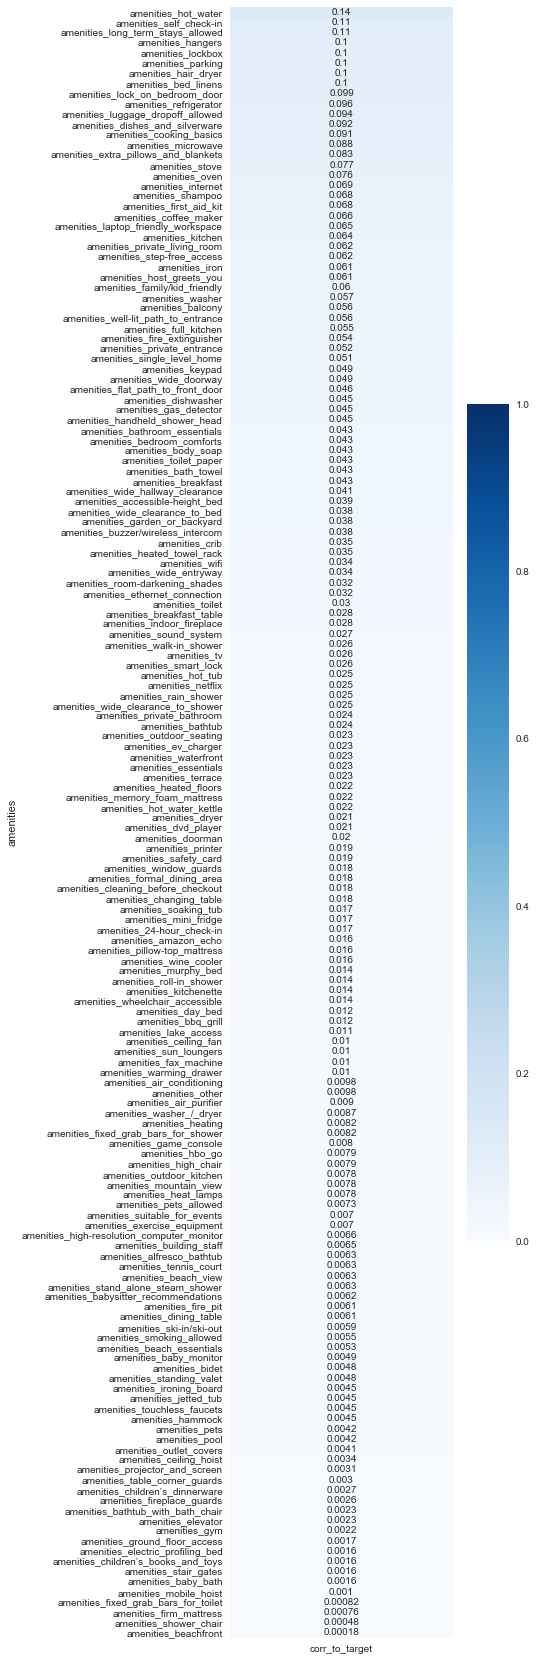

In [58]:
#calculate correlation of amenities indicators w.r.t to target indicator
amenities_to_target_corr = amenities_df.corr()['revenue_var_positive'].sort_values(ascending=False).reset_index()

#rename columns
amenities_to_target_corr.rename(
    columns={'index':'amenities','revenue_var_positive':'corr_to_target'},inplace=True)

#drop amenities with nan correlation
amenities_to_target_corr = amenities_to_target_corr.dropna()

#make correlation absolute (to take into account high negative correlation)
amenities_to_target_corr['corr_to_target'] = \
abs(amenities_to_target_corr['corr_to_target'])

#remove the target from the correlation table
amenities_to_target_corr = \
amenities_to_target_corr[amenities_to_target_corr['amenities']!='revenue_var_positive'].reset_index(drop=True)

#order amenities based on absolute correlation with target
amenities_to_target_corr = \
amenities_to_target_corr.sort_values(by='corr_to_target',ascending=False).reset_index(drop=True)

#show heat map of correlations with target
fig = plt.figure(figsize=(5,30))
sns.heatmap(amenities_to_target_corr.set_index('amenities'),vmin=0,vmax=1,annot=True,cmap='Blues')

No real change - use (new) amenities with a correlation greater than 0.1, discard the rest

In [59]:
#add indicators to main dataset which have correlation greater than 0.1
threshold = amenities_to_target_corr['corr_to_target']>0.1
amenities_top = list(amenities_to_target_corr.loc[(threshold),'amenities'])
listings = listings.join(amenities_df[amenities_top])

#delete original and new amenities fields from main dataset
listings.drop(['amenities','amenities_new'],axis=1,inplace=True)

### Impute missing values
For boolean features remove missing values, for real valued features impute missing values with median (more resistant than mean against extreme values)

Text(0.5,1,'missing values percentages')

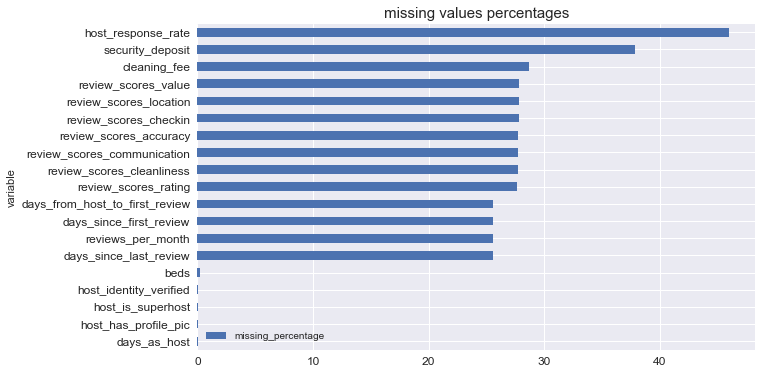

In [60]:
#get variables with missing values, along with missing value counts, and percentages
missing_values = pd.DataFrame(listings.isnull().sum().sort_values(ascending=False)).reset_index()
missing_values['missing_percentage'] = missing_values[0]/listings.shape[0]*100
missing_values.columns = ['variable','missing_count','missing_percentage']
missing_values = missing_values[missing_values['missing_count']>0]

#show missing value percentages for these variables
missing_values.sort_values(by='missing_percentage',ascending=True).plot(x='variable',y='missing_percentage',\
                                                                        kind='barh',figsize=(10,6),fontsize=12)
plt.title('missing values percentages',fontsize=15)

[Text(0.5,0,'host_response_rate'),
 Text(1.5,0,'security_deposit'),
 Text(2.5,0,'cleaning_fee'),
 Text(3.5,0,'review_scores_value'),
 Text(4.5,0,'review_scores_location'),
 Text(5.5,0,'review_scores_checkin'),
 Text(6.5,0,'review_scores_accuracy'),
 Text(7.5,0,'review_scores_communication'),
 Text(8.5,0,'review_scores_cleanliness'),
 Text(9.5,0,'review_scores_rating'),
 Text(10.5,0,'days_from_host_to_first_review'),
 Text(11.5,0,'days_since_first_review'),
 Text(12.5,0,'reviews_per_month'),
 Text(13.5,0,'days_since_last_review'),
 Text(14.5,0,'beds'),
 Text(15.5,0,'host_is_superhost'),
 Text(16.5,0,'host_has_profile_pic'),
 Text(17.5,0,'host_identity_verified'),
 Text(18.5,0,'days_as_host')]

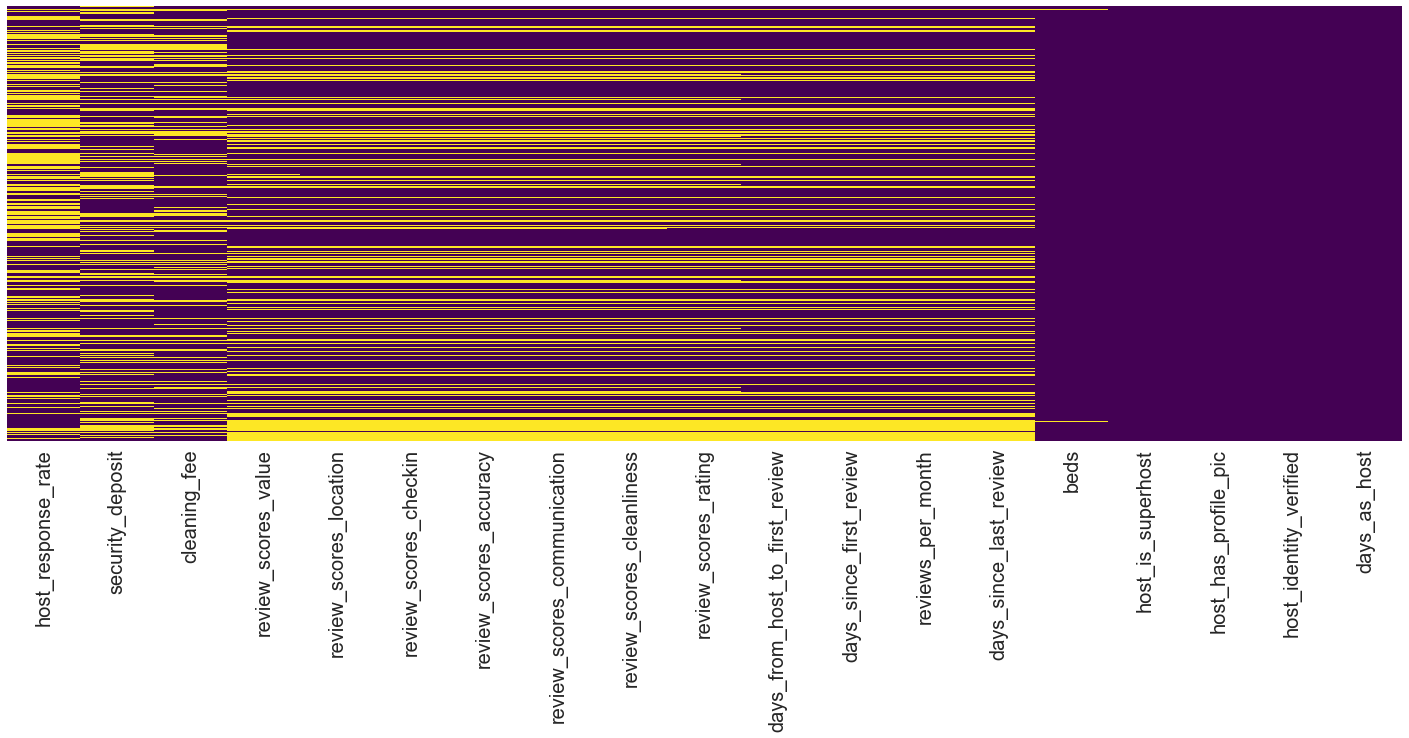

In [61]:
#plot heat map showing missing values across features
listings_mv = listings[list(missing_values['variable'])]

plt.figure(figsize=(25,8))
ax = sns.heatmap(listings_mv.isnull(),yticklabels=False, cbar=False, cmap='viridis')
ax.set_xticklabels(list(listings_mv.columns), fontsize=20)

**Boolean (indicator) features:**

In [62]:
#Get indicator variables with missing values
ind_list_mv = []
for variable in list(listings_mv.columns):
    is_ind = (sorted(list(listings_mv[variable].fillna(-1).unique()))==[-1,0,1])|\
    (sorted(list(listings_mv[variable].fillna(-1).unique()))==[-1,0])|\
    (sorted(list(listings_mv[variable].fillna(-1).unique()))==[-1,1])
    if is_ind:
        ind_list_mv.append(variable)

#get truth condition which flags up rows where indicators have missing values, in order to delete these rows
df_ind_mv = pd.DataFrame(index=list(listings.index),columns=ind_list_mv)

for variable in ind_list_mv:
    df_ind_mv[variable] = (listings[variable].isnull()*1)

ind_has_mv = (df_ind_mv.T.sum()>0).T

#number of rows to delete
print('number of rows:',ind_has_mv.sum())


number of rows: 34


In [63]:
#only 34 rows - delete
print('row count before deletion: '+str(listings.shape[0]))
listings = listings[ind_has_mv==False].reset_index(drop=True)
print('row count after deletion: '+str(listings.shape[0]))

row count before deletion: 72927
row count after deletion: 72893


**Real valued features:**

In [64]:
#impute missing values with median
variables_mv = list(missing_values['variable'])

for variable in variables_mv:
    listings[variable]=listings[variable].fillna(listings[variable].median())

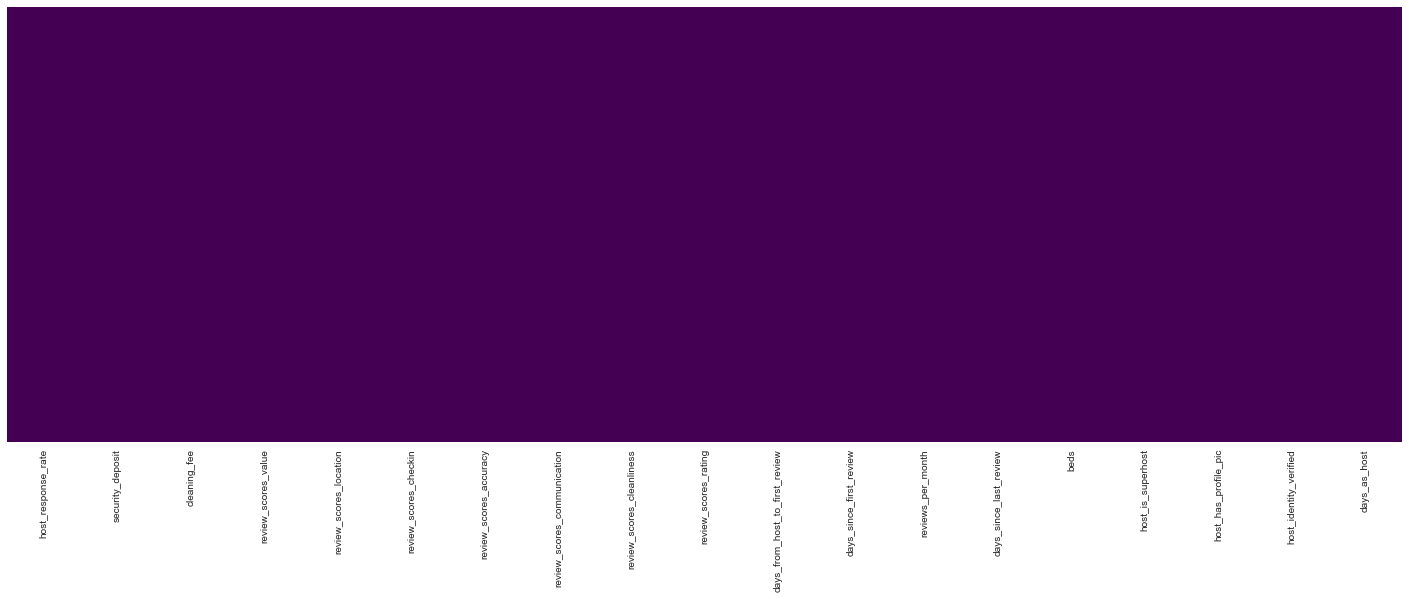

In [65]:
#check there are no missing values remaining
plt.figure(figsize=(25,8))
sns.heatmap(listings[list(missing_values['variable'])].isnull(),yticklabels=False, cbar=False, cmap='viridis')

### Feature Selection 
Remove indicator features which are all 1's or 0's (no predictive power); remove highly correlated features (they are redundant)

In [66]:
#remove indicator features which are all 1's or 0's

#get these indicators
ind_var_list = []
for column in list(listings.columns):
    is_completely_0_or_1 = (len(listings[column].unique())==1)
    if is_completely_0_or_1:
        ind_var_list.append(column)

#delete these indicators
listings.drop(ind_var_list,axis=1,inplace=True)

#print deleted indicators
print('indicators deleted:',ind_var_list)

indicators deleted: ['has_availability', 'is_business_travel_ready', 'host_name_included']


Create feature correlation heat map:

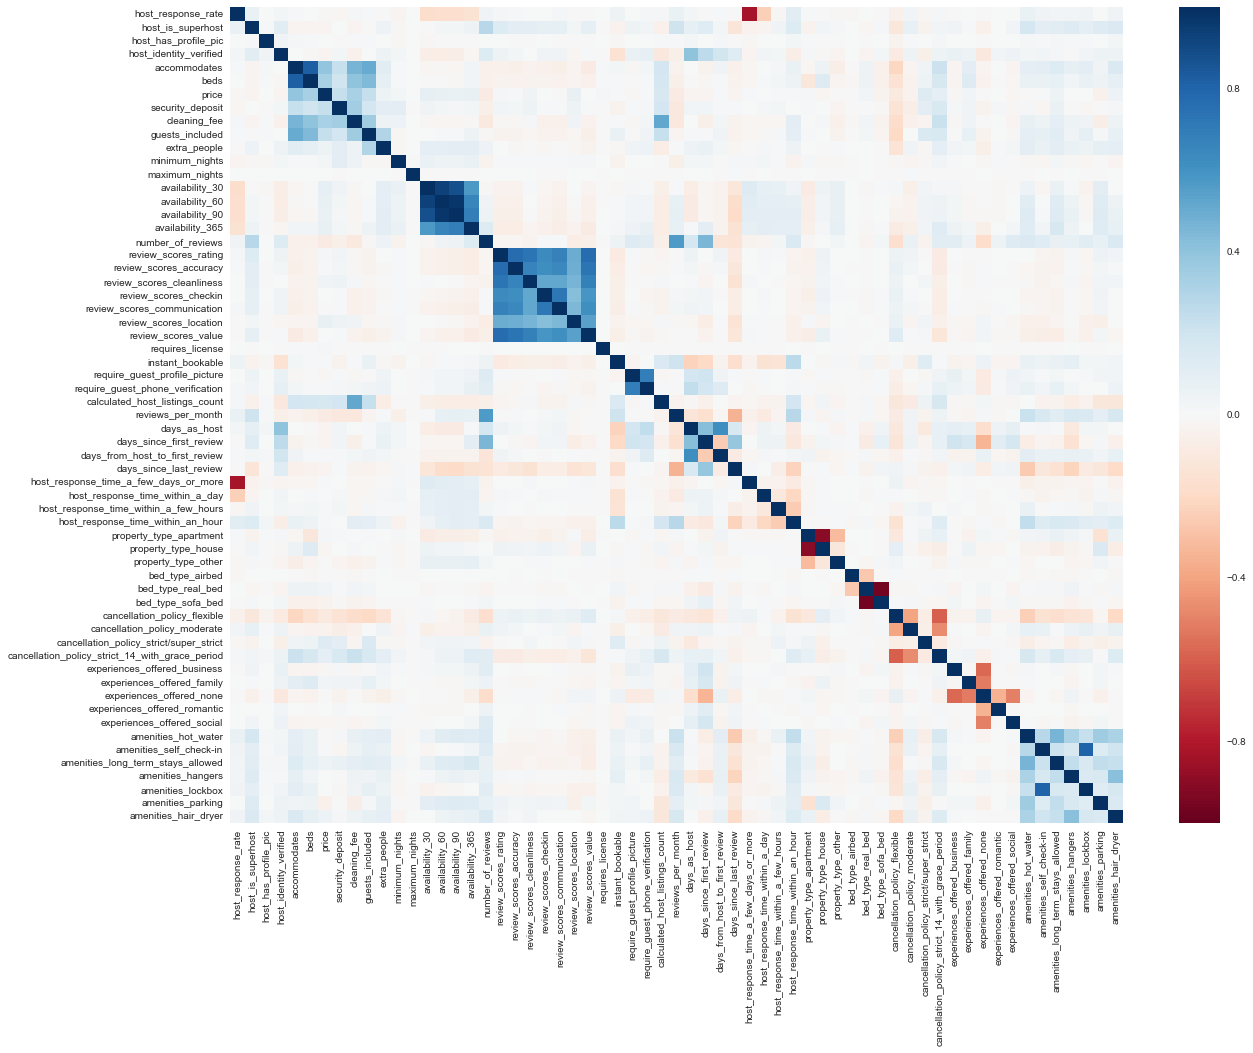

In [67]:
#remove target
pred_vars = listings.drop(['revenue_var'], axis=1)

#create matrix showing pairwise correlations of all features
corr_matrix = pred_vars.corr()
plt.figure(figsize=(20,15))
sns.heatmap(corr_matrix,cmap='RdBu',vmin=-1,vmax=1)

In [68]:
#capture highly correlated feature groupings (features with >.9 or <.9 correlation)
corr_vars = []
for variable in list(corr_matrix.columns):
    threshold = ((abs(corr_matrix[variable])>=0.90) & (corr_matrix.index!=variable))
    if len(corr_matrix.loc[(threshold),variable])>0:
        var_list = list(corr_matrix.loc[(threshold),variable].index)
        var_list.append(variable)
        corr_vars.append(var_list)
corr_vars = list(map(list,set(tuple(sorted(k)) for k in corr_vars)))
corr_vars

[['property_type_apartment', 'property_type_house'],
 ['availability_30', 'availability_60'],
 ['bed_type_real_bed', 'bed_type_sofa_bed'],
 ['availability_60', 'availability_90'],
 ['availability_30', 'availability_60', 'availability_90']]

In [69]:
#pick member from each group, discard the rest

#create dictionary with key as first element in each group, and the rest as the associated value for that key.
dicts = {}
for i in range(len(corr_vars)):
    dicts[corr_vars[i][0]] = corr_vars[i][1:]
dicts

#keep first feature from each group (i.e. key of each dictionary), discard the rest
for key in list(dicts.keys()):
    for item in dicts[key]:
        if item in list(listings.columns):
            listings.drop(item,axis=1,inplace=True)

### Check final dataset

In [70]:
#Check number of rows and columns:
listings.shape

(72893, 58)

In [71]:
#check list of features and sample values.
listings.head(2).T

0            1
host_response_rate                                100.00000   100.000000
host_is_superhost                                   1.00000     0.000000
host_has_profile_pic                                1.00000     1.000000
host_identity_verified                              0.00000     0.000000
accommodates                                        2.00000     2.000000
beds                                                1.00000     1.000000
price                                              35.00000    70.000000
security_deposit                                  100.00000   100.000000
cleaning_fee                                        7.00000    30.000000
guests_included                                     1.00000     2.000000
extra_people                                       15.00000    35.000000
minimum_nights                                      1.00000     2.000000
maximum_nights                                    730.00000  1125.000000
availability_30                                     0.00000    14.000000
availability_365                                  299.00000    14.000000
number_of_reviews                                 133.00000     2.000000
review_scores_rating                               97.00000    90.000000
review_scores_accuracy                             10.00000     8.000000
review_scores_cleanliness                           9.00000     9.000000
review_scores_checkin                              10.00000    10.000000
review_scores_communication                        10.00000     9.000000
review_scores_location                              9.00000     9.000000
review_scores_value                                10.00000     9.000000
requires_license                                    0.00000     0.000000
instant_bookable                                    0.00000     1.000000
require_guest_profile_picture                       1.00000     0.000000
require_guest_phone_verification                    0.00000     0.000000
calculated_host_listings_count                      4.00000     6.000000
reviews_per_month                                   1.69000     0.070000
revenue_var                                       148.75506  -391.089153
days_as_host                                     3340.00000  3301.000000
days_since_first_review                          2354.00000   914.000000
days_from_host_to_first_review                    986.00000  2387.000000
days_since_last_review                             54.00000   682.000000
host_response_time_a_few_days_or_more               0.00000     0.000000
host_response_time_within_a_day                     0.00000     0.000000
host_response_time_within_a_few_hours               0.00000     0.000000
host_response_time_within_an_hour                   1.00000     0.000000
property_type_apartment                             1.00000     1.000000
property_type_other                                 0.00000     0.000000
bed_type_airbed                                     0.00000     0.000000
bed_type_real_bed                                   1.00000     1.000000
cancellation_policy_flexible                        0.00000     0.000000
cancellation_policy_moderate                        0.00000     0.000000
cancellation_policy_strict/super_strict             0.00000     0.000000
cancellation_policy_strict_14_with_grace_period     1.00000     1.000000
experiences_offered_business                        0.00000     0.000000
experiences_offered_family                          0.00000     0.000000
experiences_offered_none                            1.00000     1.000000
experiences_offered_romantic                        0.00000     0.000000
experiences_offered_social                          0.00000     0.000000
amenities_hot_water                                 0.00000     0.000000
amenities_self_check-in                             0.00000     0.000000
amenities_long_term_stays_allowed                   0.00000     0.000000
amenities_hangers                          

**NB:** All the above features can be thought of as 'host controllable'.

**Variable Definitions Table**

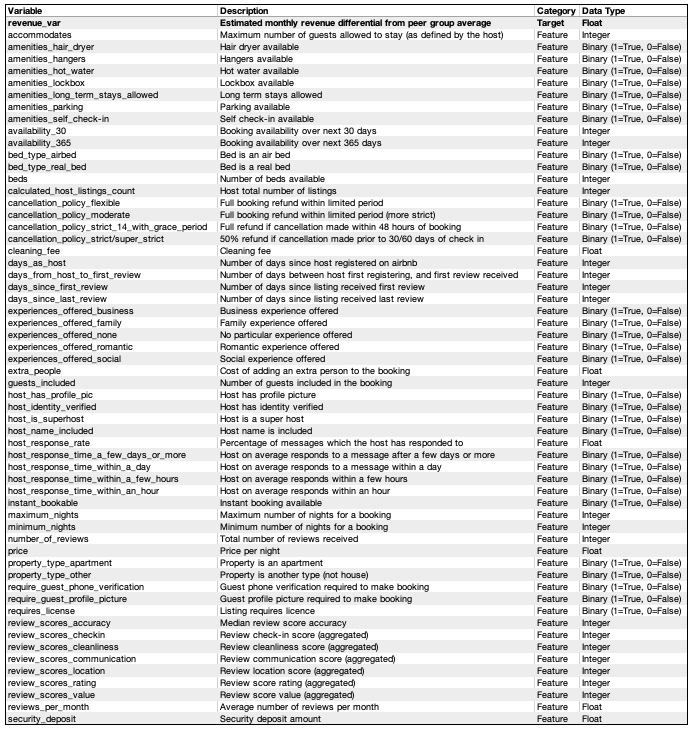

In [72]:
Image(filename='principles data dictionary.png')

## Exploratory Data Analysis
Explore distribution of features and relationship with target

**Real-valued features**

In [73]:
#get variables
cont_vars_list = []
for column in list(listings.columns):
    is_cont = len(listings[column].fillna(-1).unique())>3
    if is_cont==True:
        cont_vars_list.append(column)

#create separate dataframe just with variables
cont_vars = listings[cont_vars_list].copy()

#how many features are there?
print('count: ',(len(cont_vars_list)),'\n',cont_vars_list)

count:  27 
 ['host_response_rate', 'accommodates', 'beds', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'reviews_per_month', 'revenue_var', 'days_as_host', 'days_since_first_review', 'days_from_host_to_first_review', 'days_since_last_review']


<Figure size 432x288 with 0 Axes>

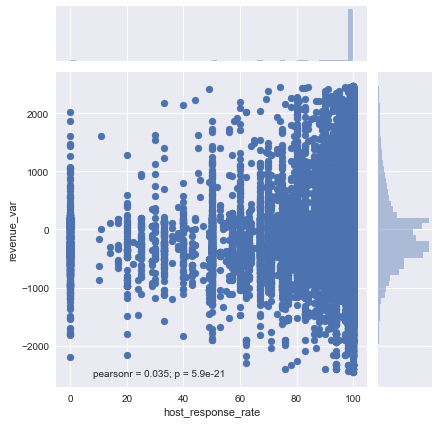

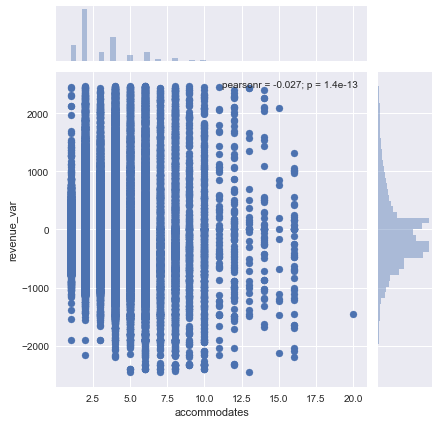

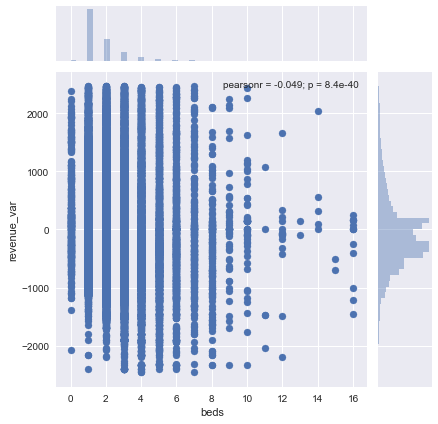

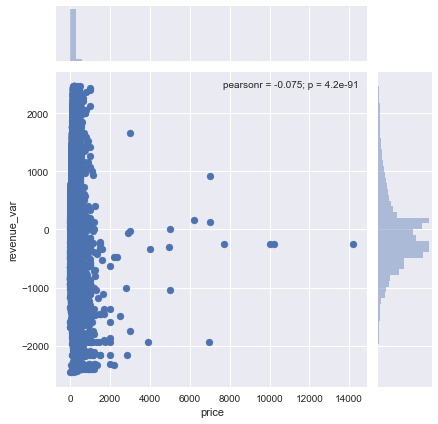

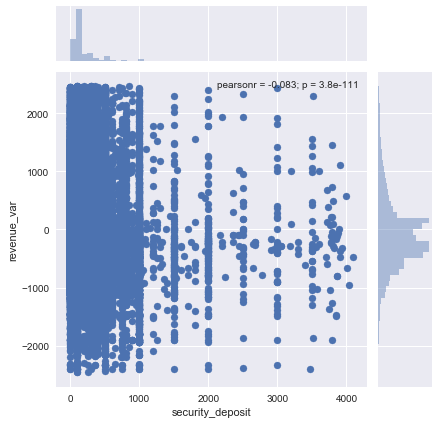

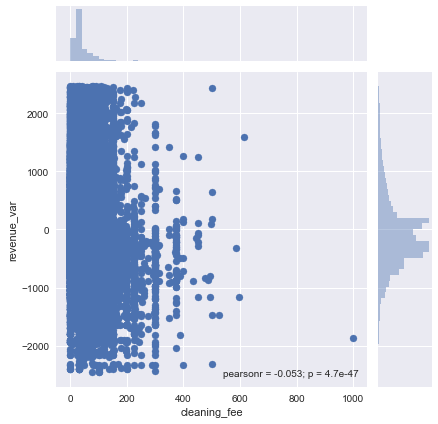

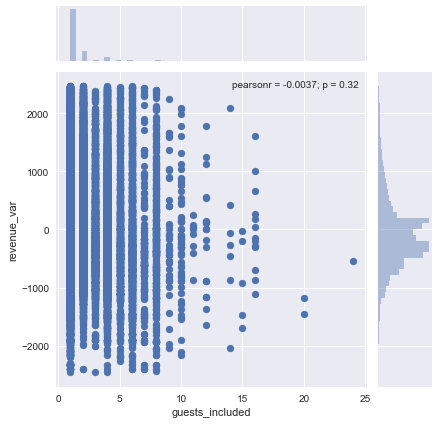

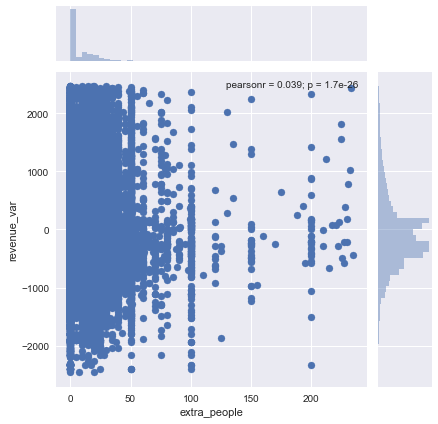

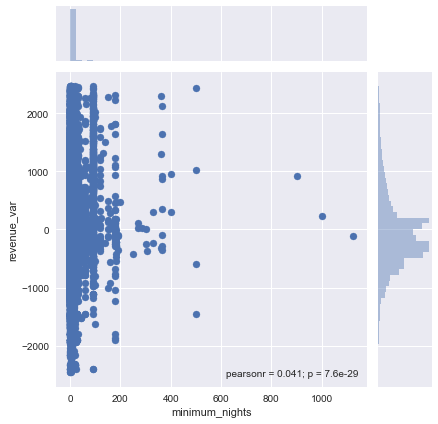

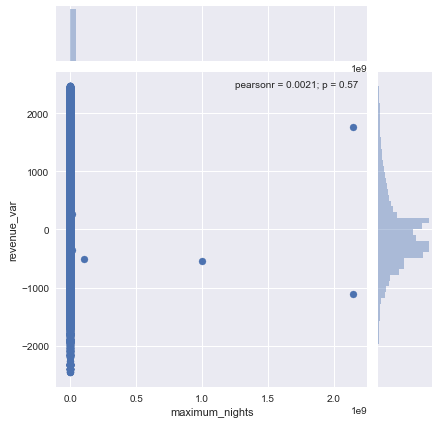

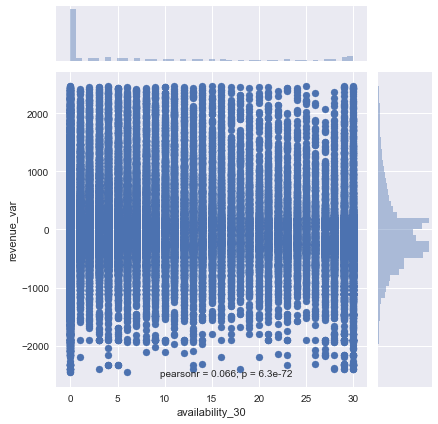

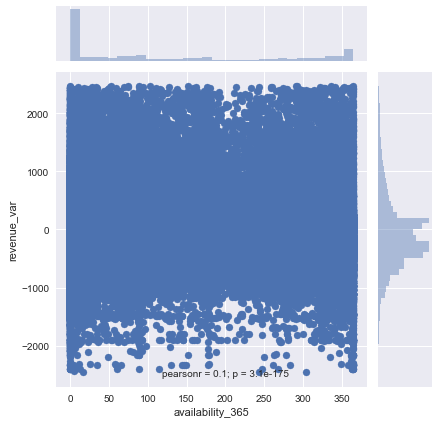

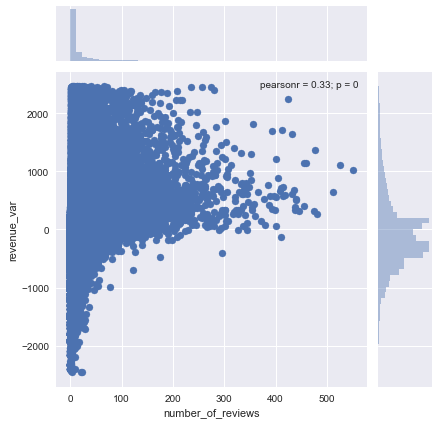

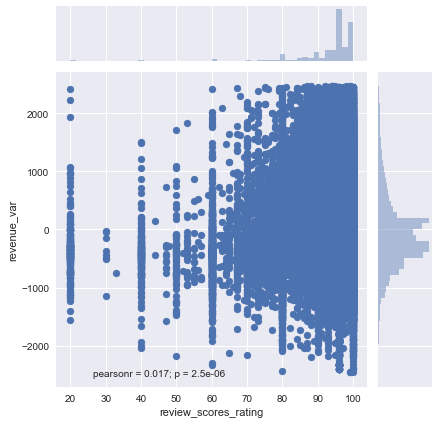

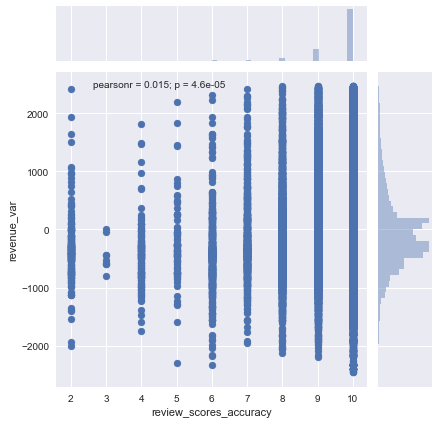

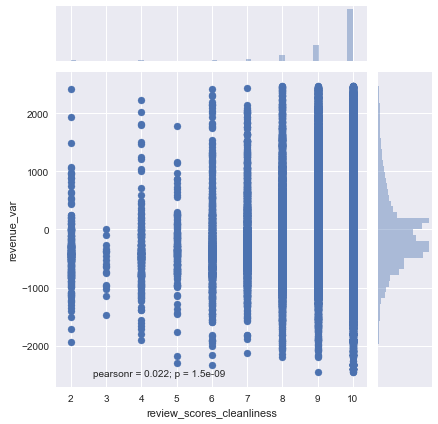

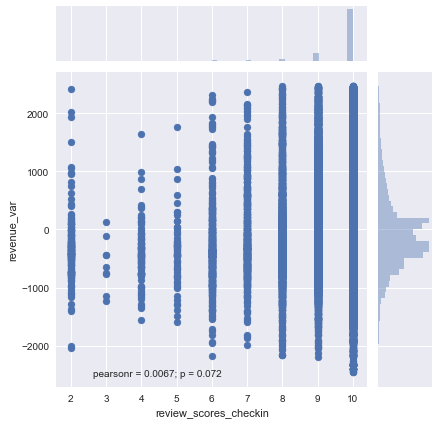

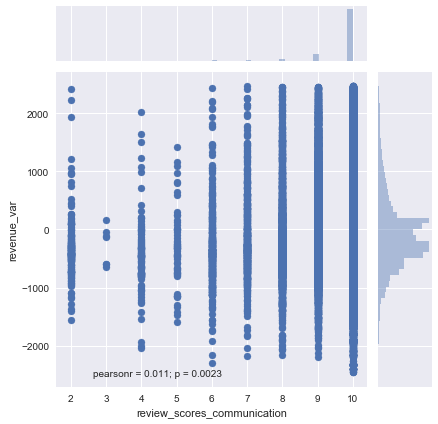

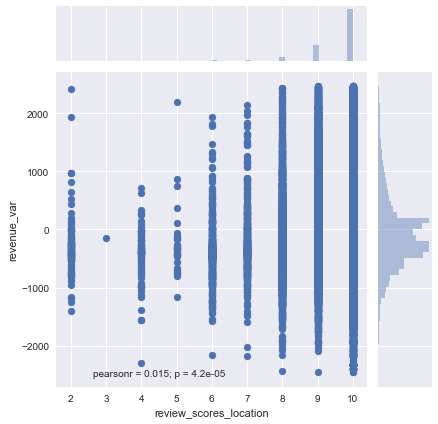

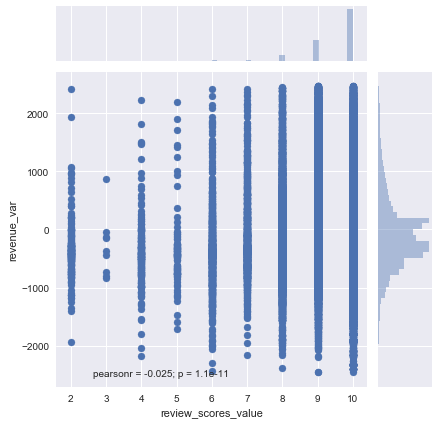

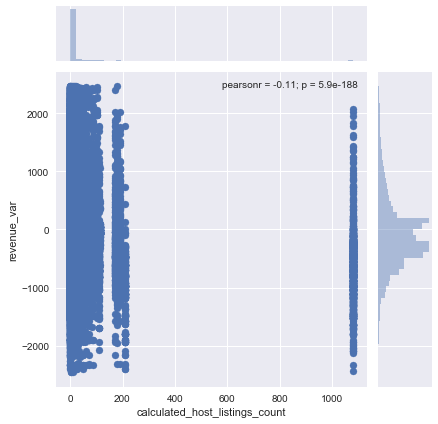

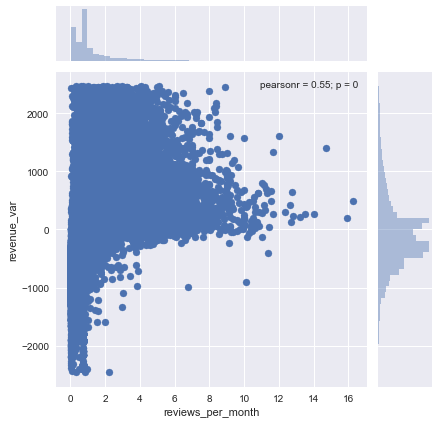

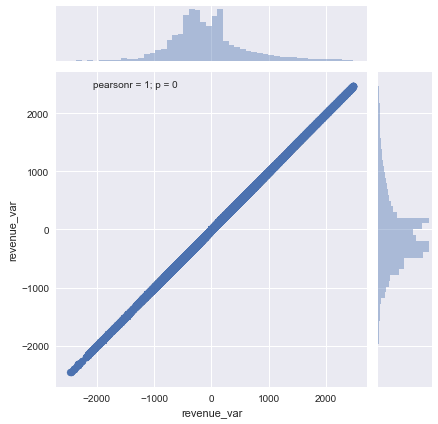

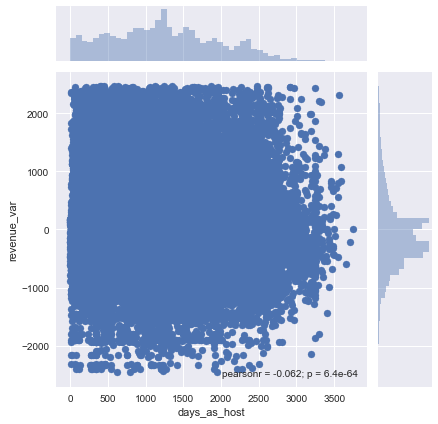

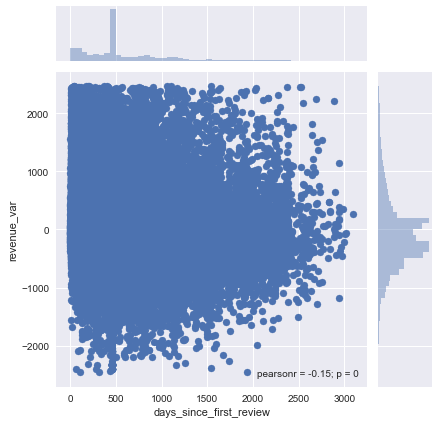

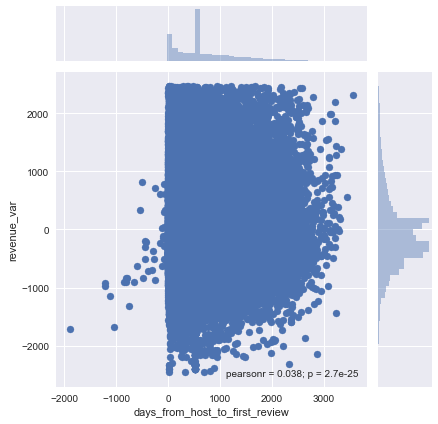

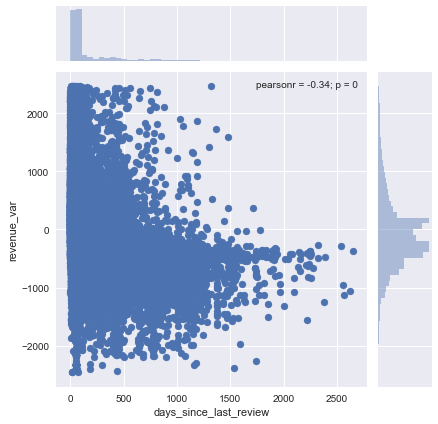

In [74]:
#check distribution of features and relationship with target
for i, var in enumerate(cont_vars.columns):
    plt.figure(i)
    sns.jointplot(x=var,y='revenue_var',data=listings)

Features not normally distributed. Only features showing correlation with target are 'reviews' related - due to way revenue has been estimated.

Irregularities observed with certain features.

**Maximum Nights:**

In [75]:
#summary stats
listings['maximum_nights'].describe().apply(lambda x: format(x,'f'))

count         72893.000000
mean          75040.511874
std        11848545.245760
min               1.000000
25%              31.000000
50%            1125.000000
75%            1125.000000
max      2147483647.000000
Name: maximum_nights, dtype: object

In [76]:
#huge values present in variable - contradicts london 90-day short-let cap. Remove this feature.
listings.drop('maximum_nights',axis=1,inplace=True)

**Days from host to first review**

In [77]:
#negative values observed which doesn't make sense - check how many
(listings['days_from_host_to_first_review']<0).value_counts()

False    72853
True        40
Name: days_from_host_to_first_review, dtype: int64

In [78]:
#only 40 - remove them
is_negative = (listings['days_from_host_to_first_review']<0)
listings = listings[is_negative==False].reset_index(drop=True)

**Explore binary features**  

In [79]:
#get features
cat_vars_list = []
for column in list(listings.columns):
    is_cont = len(listings[column].fillna(-1).unique())>3
    if is_cont==False:
        cat_vars_list.append(column)

#create separate dataframe just with categorical variables
cat_vars = listings[cat_vars_list].copy()

#how many features are there?
print('count: ',len(cat_vars_list),'\n',cat_vars_list)

count:  31 
 ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'requires_license', 'instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification', 'host_response_time_a_few_days_or_more', 'host_response_time_within_a_day', 'host_response_time_within_a_few_hours', 'host_response_time_within_an_hour', 'property_type_apartment', 'property_type_other', 'bed_type_airbed', 'bed_type_real_bed', 'cancellation_policy_flexible', 'cancellation_policy_moderate', 'cancellation_policy_strict/super_strict', 'cancellation_policy_strict_14_with_grace_period', 'experiences_offered_business', 'experiences_offered_family', 'experiences_offered_none', 'experiences_offered_romantic', 'experiences_offered_social', 'amenities_hot_water', 'amenities_self_check-in', 'amenities_long_term_stays_allowed', 'amenities_hangers', 'amenities_lockbox', 'amenities_parking', 'amenities_hair_dryer']


Show correlation of each feature with success/failure binary target:

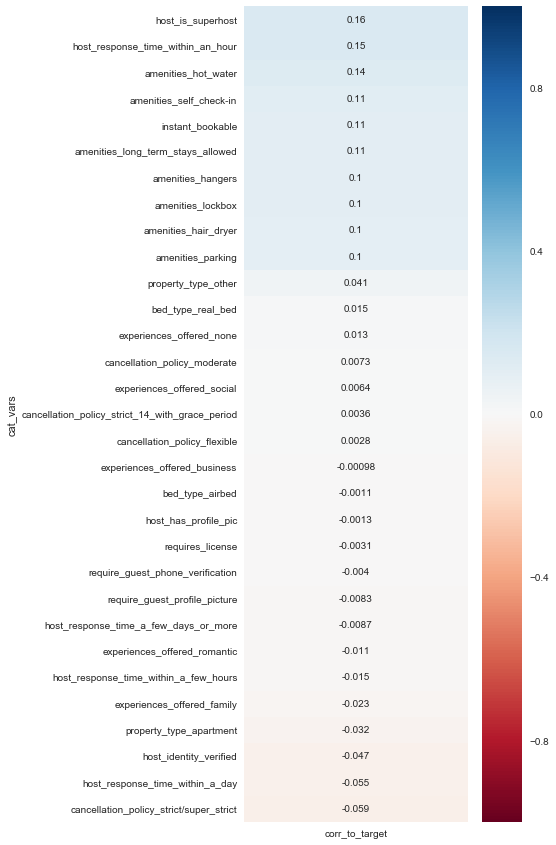

In [80]:
#define binary target (listing revenue over/below peer group average)
target = (listings['revenue_var']>0)*1

#add target to features data
cat_vars['revenue_var_positive'] = target

#calculate correlation of indicators w.r.t to target indicator
corr_cats_to_target = cat_vars.corr()['revenue_var_positive'].sort_values(ascending=False).reset_index()

#rename columns
corr_cats_to_target.rename(
    columns={'index':'cat_vars','revenue_var_positive':'corr_to_target'},inplace=True)

#drop features with nan correlation
corr_cats_to_target = corr_cats_to_target.dropna()

#remove the target from the correlation table
corr_cats_to_target = \
corr_cats_to_target[corr_cats_to_target['cat_vars']!='revenue_var_positive'].reset_index(drop=True)

#order amenities based on correlation with target
corr_cats_to_target = \
corr_cats_to_target.sort_values(by='corr_to_target',ascending=False).reset_index(drop=True)

#plot heatmap showing correlation of each categorical feature with target
plt.figure(figsize=(5,15))
sns.heatmap(corr_cats_to_target.set_index('cat_vars'),cmap='RdBu',annot=True,vmin=-1,vmax=1)

## Modelling

**Aim:** Train models capturing/explaining how features map to target

**Key points to note:**
* From EDA, no strong correlations found between features and target - this makes regression models difficult
* Simple binary classification models would have best chance at extracting some signal from data.
* Let's train parametric and non-parametric classifier to see different signals they pick up

**Binary target class:** listing monthly revenue above/below peer average (i.e. target greater/less than 0)   
**Parametric model:** Logistic Regression Classifier    
**Non-parametric model:** Random Forest Classifier

### Import modules

In [81]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale
from matplotlib import cm
import itertools

### Logistic Regression Model
Models log odds of success class - log of success to failure class ratio - as linear combination of features. Fits this relationship on training data, and uses it to predict probability of success for new data points (and hence whether to class as success/failure)

**Fit model on entire feature space:**

In [82]:
#Define features and target
X = listings.drop('revenue_var',axis=1)
y = (listings['revenue_var']>0)*1 

#Define training and test sets - one for fitting the model, the other for testing model performance
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=101)

#fit model
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

#make predictions on the test set features
logmodel_predictions = logmodel.predict(X_test)

Create function to visualise confusion matrix for model. Shows number of correct/incorrect predictions on test set (per class), compared to actual class labels (values).

In [83]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**Evaluate model performance:**

Confusion matrix, without normalization
[[12925  1290]
 [ 3374  6453]]


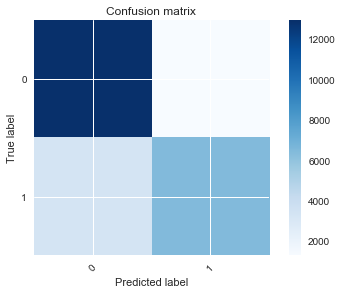

In [84]:
#plot confusion matrix
plot_confusion_matrix(
    cm=confusion_matrix(y_test,logmodel_predictions),
    classes=sorted(list(y.unique()))
)

More correct than incorrect predictions. Better at correctly predicting failure (likely due to slight class imbalance). 

Print classification report (performance metrics based on confusion matrix)

In [85]:
print(classification_report(y_test,logmodel_predictions))

             precision    recall  f1-score   support

          0       0.79      0.91      0.85     14215
          1       0.83      0.66      0.73      9827

avg / total       0.81      0.81      0.80     24042



Good overall accuracy, more precise with success class, but not very comprehensive.

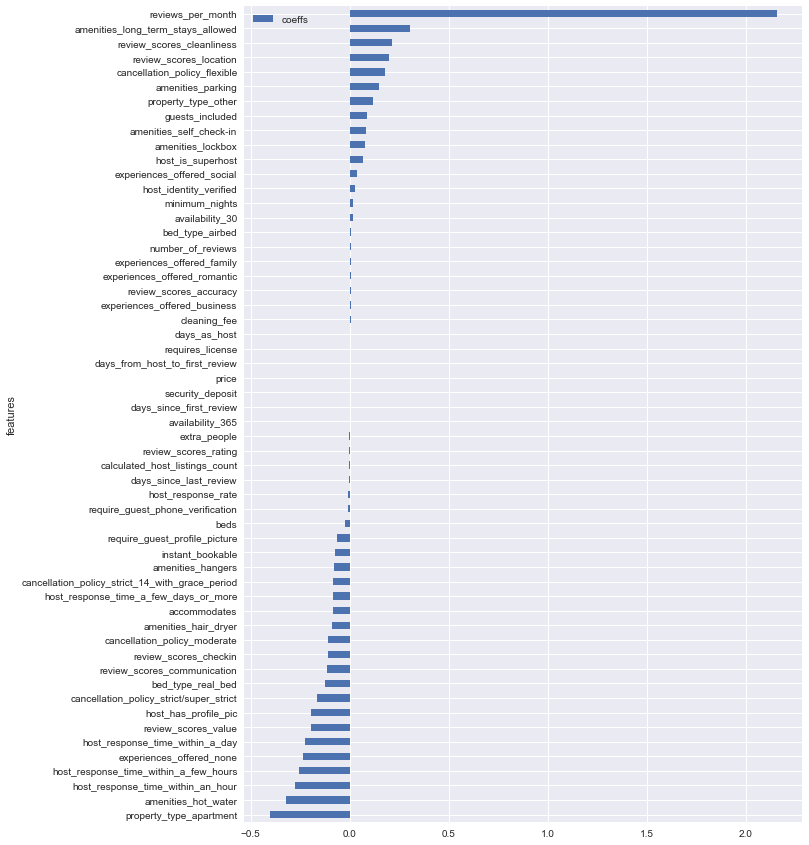

In [86]:
#plot feature coefficients in model
feature_coeffs = pd.DataFrame(list(X_train.columns),columns=['features'])
feature_coeffs['coeffs'] = pd.DataFrame(list(logmodel.coef_[0]),columns=['coeffs'])
feature_coeffs['coeffs'] = feature_coeffs['coeffs'].apply(lambda x: float(format(x, 'f')))
feature_coeffs.sort_values(by='coeffs',ascending=True).plot(x='features',y='coeffs',kind='barh',figsize=(10,15))

Reviews per month has largest positive coefficient. Due to target being defined based on number of reviews (i.e. proxy for revenue). Remove this variable from analysis.

             precision    recall  f1-score   support

          0       0.75      0.77      0.76     14215
          1       0.65      0.62      0.64      9827

avg / total       0.71      0.71      0.71     24042

Confusion matrix, without normalization
[[11007  3208]
 [ 3744  6083]]


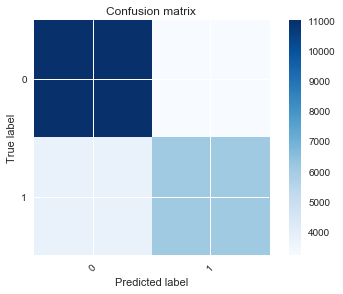

In [87]:
#retrain model without number of reviews

#prepare features and target
X = listings.drop(['revenue_var','number_of_reviews','reviews_per_month'],axis=1)
y = (listings['revenue_var']>0)*1 

#get train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=101)

#initialise and train model, and make predictions on test set
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
logmodel_predictions = logmodel.predict(X_test)

#evaluate predictive performance with classification report and confusion matrix
print(classification_report(y_test,logmodel_predictions))

plot_confusion_matrix(
    cm=confusion_matrix(y_test,logmodel_predictions),
    classes=sorted(list(y.unique()))
)

Model accuracy has dropped, but no redundancy between features and target

**Feature Selection with PCA**    
Use Principal Component Analysis (PCA) to simplify model inputs (and make it easier to interpret) - allows to select features which are most 'informative'.

Standardise features to unit variance (z-score) - to ensure PCA gives equal weighting to all features.

In [88]:
#get continuous variables
cont_vars_list = []
for column in list(listings.columns):
    is_cont = len(listings[column].fillna(-1).unique())>3
    if is_cont==True:
        cont_vars_list.append(column)

#create separate dataframe just with continuous variables
cont_vars = listings[cont_vars_list].copy()

#standardise continuous variables using z-score
scaler = StandardScaler()
cont_vars_s = pd.DataFrame(scaler.fit_transform(listings[cont_vars_list]),columns=cont_vars_list)

#create copy of dataset with standardised variables
listings_s = listings.copy()
for variable in list(listings_s[cont_vars_list].columns):
    listings_s[variable] = cont_vars_s[variable]

Get principal components explaining 90% of variance in data:

explained variance:  [ 0.18038942  0.30109272  0.37279901  0.43955107  0.49705582  0.54456389
  0.58383276  0.62165374  0.65767903  0.68970898  0.71766203  0.74305729
  0.76688999  0.7895328   0.80957857  0.82716172  0.84260154  0.85659736
  0.86903495  0.88070033  0.89107867  0.90120334  0.91080041  0.91967433
  0.92748406]


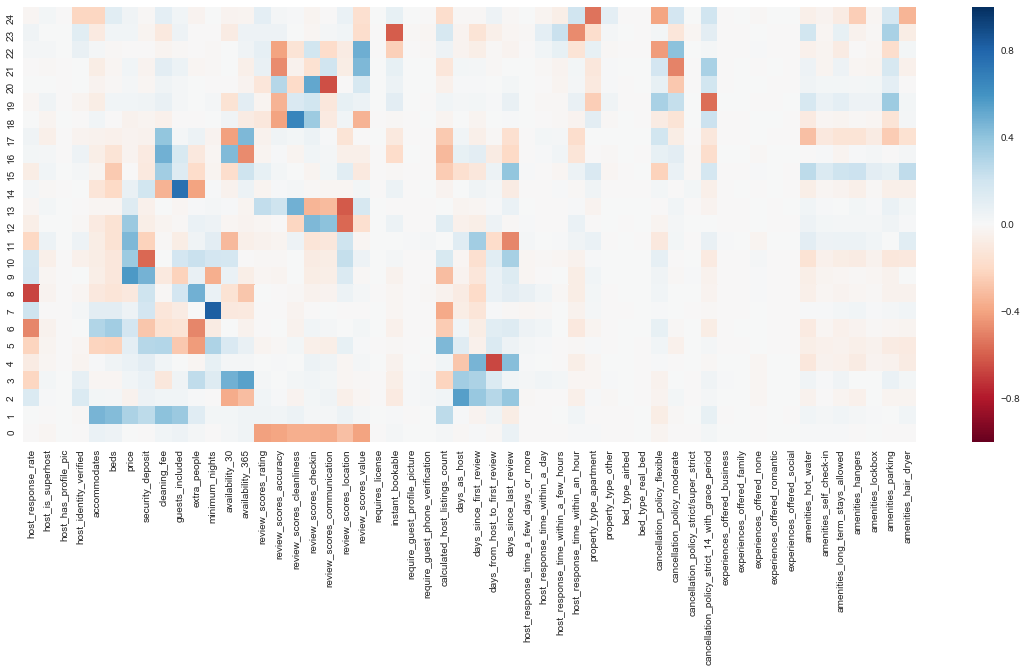

In [89]:
#Define standardised dataset to perform PCA on
X = listings_s.drop(['revenue_var','reviews_per_month','number_of_reviews'],axis=1)

#create pca model
pca = PCA(n_components=25)

#fit model to features
pca.fit(X)

#print cumulative percentage of variance in data explained by each component
explained_variance = pca.explained_variance_ratio_.cumsum()
print('explained variance: ',explained_variance)

#show factor loadings of features for each principle
df_comp = pd.DataFrame(pca.components_,columns=list(X.columns))
plt.figure(figsize=(20,8))
sns.heatmap(df_comp,cmap='RdBu',vmin=-1,vmax=1).invert_yaxis()

#90% of variance explained by first 22 principal components

Explore first 5 components:

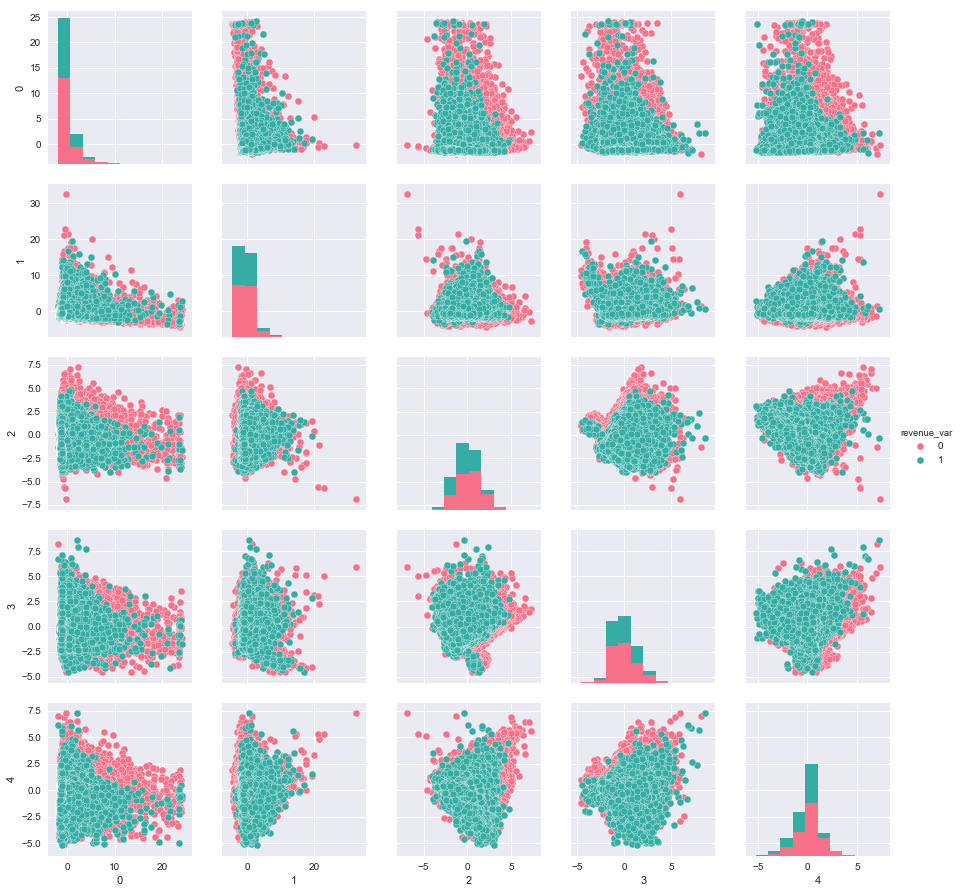

In [90]:
#get principle components
pca_comps = pca.fit_transform(X)

#store as dataframe
pca_comps_df = pd.DataFrame(pca_comps)

#get first 5 components
pca_comps_subset = list(range(5))
pca_comps_subset_df = pca_comps_df[pca_comps_subset].join(target)

#plot them in pairplot to see whether they can help discriminate between classes
sns.pairplot(data=pca_comps_subset_df,palette='husl',hue='revenue_var',\
             x_vars=pca_comps_subset,y_vars=pca_comps_subset)

2nd Component looks quite discriminative of target.

Perform feature selection based on PCA factor loadings:

In [91]:
#define function to do this

#create function which returns list of features which exceed loading threshold across n first components.
def pca_important_feats(first_n_comps,loading_threshold,print_messages=1):
    important_feats = []
    for i in range(first_n_comps):
        threshold = abs(df_comp.loc[i])>loading_threshold
        features = list(df_comp.loc[i][threshold].index)
        [important_feats.append(feat) for feat in features]
    important_feats = list(set(important_feats))
    if print_messages==1:
        print('explained variance: ',explained_variance[first_n_comps-1], '\n')
        print('feature count: ',len(important_feats),'\n')
        print(important_feats, '\n')
    return important_feats

Retrain model on most important features for first 2 components (loading threshold = 0.15):

explained variance:  0.301092720589 

feature count:  14 

['accommodates', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_value', 'review_scores_accuracy', 'cleaning_fee', 'guests_included', 'calculated_host_listings_count', 'review_scores_location', 'review_scores_checkin', 'review_scores_rating', 'price', 'beds', 'security_deposit'] 

             precision    recall  f1-score   support

          0       0.59      0.98      0.74     14215
          1       0.36      0.02      0.03      9827

avg / total       0.49      0.59      0.45     24042

Confusion matrix, without normalization
[[13897   318]
 [ 9651   176]]


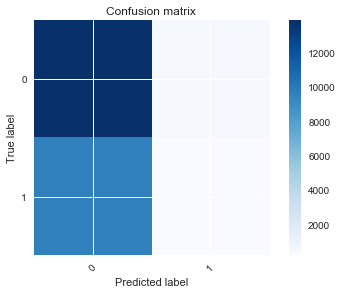

In [92]:
X = listings[pca_important_feats(2,0.15)]
y = (listings['revenue_var']>0)*1 

#get train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=101)

#initialise and train model, and make predictions on test set
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
logmodel_predictions = logmodel.predict(X_test)

#evaluate predictive performance with classification report and confusion matrix
print(classification_report(y_test,logmodel_predictions))

plot_confusion_matrix(
    cm=confusion_matrix(y_test,logmodel_predictions),
    classes=sorted(list(y.unique()))
)

Retrain on features important to first 3 components:

explained variance:  0.3727990096 

feature count:  20 

['accommodates', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_value', 'availability_365', 'review_scores_accuracy', 'days_from_host_to_first_review', 'days_since_last_review', 'cleaning_fee', 'guests_included', 'days_since_first_review', 'calculated_host_listings_count', 'review_scores_location', 'review_scores_checkin', 'review_scores_rating', 'availability_30', 'price', 'days_as_host', 'beds', 'security_deposit'] 

             precision    recall  f1-score   support

          0       0.79      0.73      0.76     14215
          1       0.64      0.71      0.68      9827

avg / total       0.73      0.72      0.72     24042

Confusion matrix, without normalization
[[10335  3880]
 [ 2824  7003]]


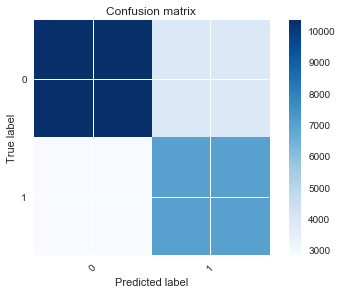

In [93]:
#pca most important features
important_feats = pca_important_feats(3,0.15)

#prepare features and target
X = listings[important_feats].copy()
y = (listings['revenue_var']>0)*1 

#get train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=101)

#initialise and train model, and make predictions on test set
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
logmodel_predictions = logmodel.predict(X_test)

#evaluate predictive performance with classification report and confusion matrix
print(classification_report(y_test,logmodel_predictions))

plot_confusion_matrix(
    cm=confusion_matrix(y_test,logmodel_predictions),
    classes=sorted(list(y.unique()))
)

On par with original model performance. Retrain on features important to first 4 components:

explained variance:  0.439551070155 

feature count:  22 

['review_scores_accuracy', 'days_from_host_to_first_review', 'review_scores_rating', 'security_deposit', 'price', 'host_response_rate', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_value', 'review_scores_checkin', 'beds', 'extra_people', 'days_since_last_review', 'availability_365', 'days_as_host', 'accommodates', 'cleaning_fee', 'guests_included', 'review_scores_location', 'calculated_host_listings_count', 'availability_30', 'days_since_first_review'] 

             precision    recall  f1-score   support

          0       0.78      0.73      0.75     14215
          1       0.64      0.71      0.67      9827

avg / total       0.73      0.72      0.72     24042

Confusion matrix, without normalization
[[10350  3865]
 [ 2864  6963]]


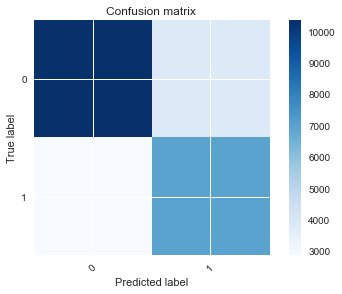

In [94]:
#pca most important features
important_feats = pca_important_feats(4,0.15)

#prepare features and target
X = listings[important_feats].copy()
y = (listings['revenue_var']>0)*1 

#get train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=101)

#initialise and train model, and make predictions on test set
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
logmodel_predictions = logmodel.predict(X_test)

#evaluate predictive performance with classification report and confusion matrix
print(classification_report(y_test,logmodel_predictions))

plot_confusion_matrix(
    cm=confusion_matrix(y_test,logmodel_predictions),
    classes=sorted(list(y.unique()))
)

No gain observed. Retrain on features important to first 22 components (in case key information left out)

explained variance:  0.901203340314 

feature count:  34 

['amenities_hot_water', 'review_scores_accuracy', 'days_from_host_to_first_review', 'cancellation_policy_strict_14_with_grace_period', 'review_scores_rating', 'security_deposit', 'price', 'amenities_parking', 'amenities_long_term_stays_allowed', 'host_response_rate', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_value', 'instant_bookable', 'property_type_apartment', 'review_scores_checkin', 'amenities_hair_dryer', 'beds', 'amenities_hangers', 'extra_people', 'days_since_last_review', 'cancellation_policy_flexible', 'host_response_time_within_an_hour', 'availability_365', 'days_as_host', 'minimum_nights', 'accommodates', 'cancellation_policy_moderate', 'cleaning_fee', 'guests_included', 'review_scores_location', 'calculated_host_listings_count', 'availability_30', 'days_since_first_review'] 

             precision    recall  f1-score   support

          0       0.75      0.75      0.75     14215
  

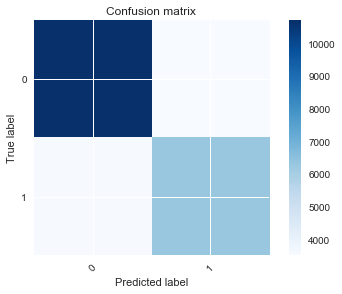

In [95]:
#pca most important features
important_feats = pca_important_feats(22,0.15)

#prepare features and target
X = listings[important_feats].copy()
y = (listings['revenue_var']>0)*1 

#get train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=101)

#initialise and train model, and make predictions on test set
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
logmodel_predictions = logmodel.predict(X_test)

#evaluate predictive performance with classification report and confusion matrix
print(classification_report(y_test,logmodel_predictions))

plot_confusion_matrix(
    cm=confusion_matrix(y_test,logmodel_predictions),
    classes=sorted(list(y.unique()))
)

No performance gain observed - we've hit the sweet spot

**K-Fold Cross Validation**  
Use this method to check for overfitting and get more realistic sense of model performace - to help decide on best number of features.

20 feature model:

In [96]:
#get features
best_feats = pca_important_feats(3,0.15,print_messages=0)

#set feature set to be equal to these features
X = listings[best_feats].copy()

logmodel = LogisticRegression()
scores = cross_val_score(logmodel,X,y,cv=10)

print('accuracy score for each run: ',scores,'\n')
print('average accuracy overall: ',scores.mean(),'\n')
print('accuracy variance: ',scores.var(),'\n')

accuracy score for each run:  [ 0.67805681  0.73716717  0.75346603  0.73946465  0.70652025  0.72312972
  0.71516815  0.72395333  0.66890872  0.57597804] 

average accuracy overall:  0.702181286468 

accuracy variance:  0.00239608442082 



22 feature model:

In [97]:
#get features
best_feats = pca_important_feats(4,0.15,print_messages=0)

#set feature set to be equal to these features
X = listings[best_feats].copy()

logmodel = LogisticRegression()
scores = cross_val_score(logmodel,X,y,cv=10)

print('accuracy score for each run: ',scores,'\n')
print('average accuracy overall: ',scores.mean(),'\n')
print('accuracy variance: ',scores.var(),'\n')

accuracy score for each run:  [ 0.67476328  0.73812792  0.75058339  0.73644475  0.70555937  0.7218943
  0.71420728  0.72477694  0.67014413  0.57652711] 

average accuracy overall:  0.701302846198 

accuracy variance:  0.00234234930636 



Both models similar in accuracy and variance. 20 feature model is preferable as it's simpler.

**Explore feature coefficients:**   
Measure of feature impact on likelihood of success class

explained variance:  0.3727990096 

feature count:  20 

['accommodates', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_value', 'availability_365', 'review_scores_accuracy', 'days_from_host_to_first_review', 'days_since_last_review', 'cleaning_fee', 'guests_included', 'days_since_first_review', 'calculated_host_listings_count', 'review_scores_location', 'review_scores_checkin', 'review_scores_rating', 'availability_30', 'price', 'days_as_host', 'beds', 'security_deposit'] 



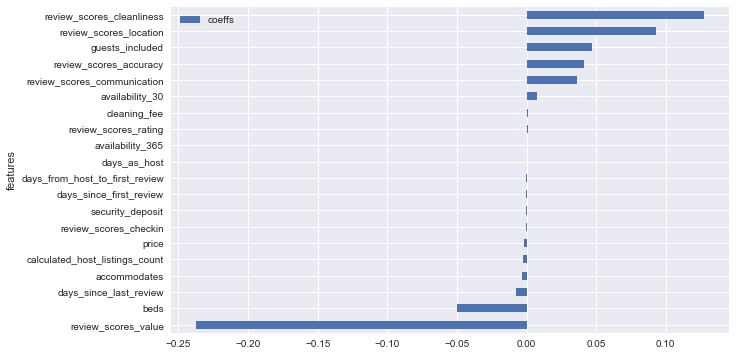

In [98]:
#pca most important features
important_feats = pca_important_feats(3,0.15)

#prepare features and target
X = listings[important_feats].copy()
y = (listings['revenue_var']>0)*1 

#get train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=101)

#initialise and train model, and make predictions on test set
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
logmodel_predictions = logmodel.predict(X_test)

#plot bar chart of feature coefficients
feature_coeffs = pd.DataFrame(list(X_train.columns),columns=['features'])
feature_coeffs['coeffs'] = pd.DataFrame(list(logmodel.coef_[0]),columns=['coeffs'])
feature_coeffs['coeffs'] = feature_coeffs['coeffs'].apply(lambda x: float(format(x, 'f')))
feature_coeffs.sort_values(by='coeffs',ascending=True).plot(x='features',y='coeffs',kind='barh',figsize=(10,6))

Explore features visually to better understand coefficients.

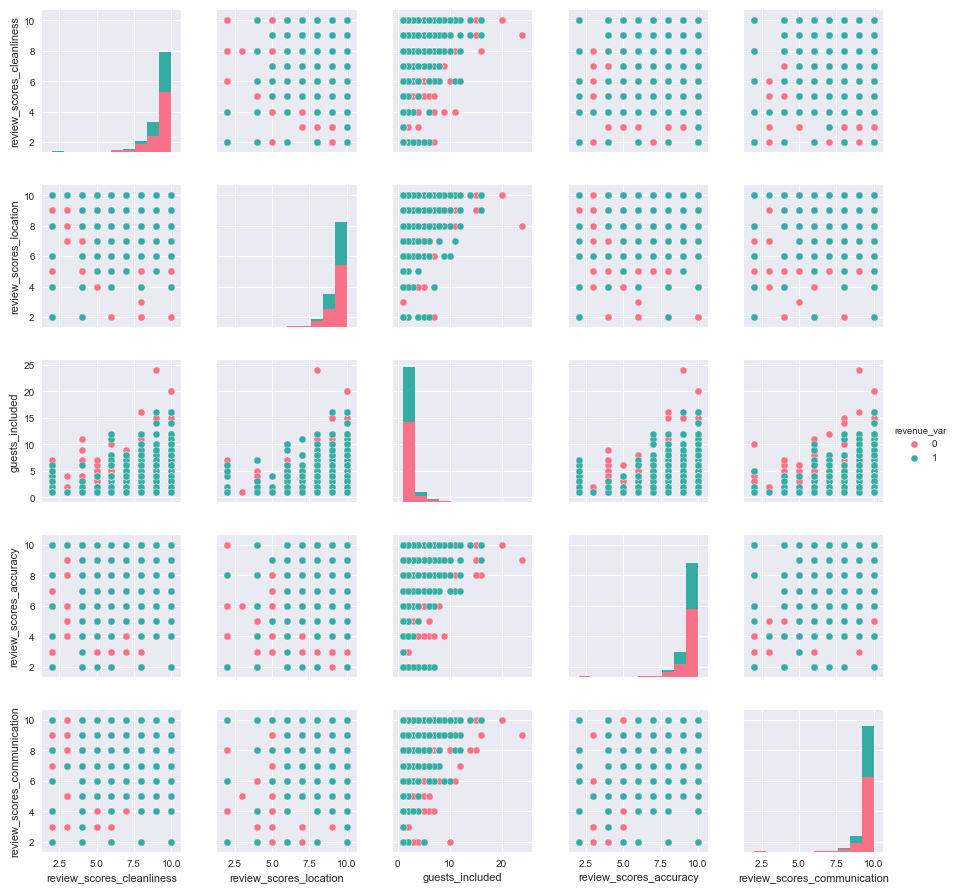

In [99]:
lr_top_feats = ['review_scores_cleanliness','review_scores_location','guests_included',\
                'review_scores_accuracy','review_scores_communication']
lr_top_feats_df = listings[lr_top_feats].join(target)
#rfc_top_feats_df.head()
sns.pairplot(data=lr_top_feats_df,palette='husl',hue='revenue_var',\
    x_vars=lr_top_feats,y_vars=lr_top_feats)

In [100]:
#function to visualise change in proportion of success class values, as feature increases

def success_rate(feature):
    
    #create copy of selected feature, along with revenue_var which will be used for aggregation purposes only
    features_df = listings[[feature,'revenue_var']].copy()
    #create copy of binary target labels
    features_df['target'] = (listings['revenue_var']>0)*1
    
    #for features consisting of more than 20 distinct values, bin them into 20 groupings to simplify bar chart visual
    if len(features_df[feature].unique())>20:
        features_df[feature] = pd.cut(listings[feature],20)
    
    #get dataframe showing row count by the selected feature and the target
    feat_df = features_df.groupby(['target',feature])[['revenue_var']].count()
    feat_df.rename(columns={'revenue_var':'count'},inplace=True)
    feat_df = feat_df.reset_index()

    #transform into matrix of features values against target labels with row counts in the middle.
    target_0 = feat_df[feat_df['target']==0].set_index(feature).drop('target',axis=1)\
    .rename(columns={'count':'0'})
    target_1 = feat_df[feat_df['target']==1].set_index(feature).drop('target',axis=1)\
    .rename(columns={'count':'1'})
    df = pd.concat([target_0,target_1],axis=1)
    
    #create total row count by feature value
    df['total'] = df['1']+df['0']
    #create success rate (percentage of success label
    df['success_rate'] = df['1']/df['total']
    
    #plot bar chart showing success rate by feature value, coloured according to total rows for each feature value
    plt.title(feature,fontsize=15)
    df['success_rate'].plot(kind='bar', figsize=(10,2))

Top 3 positive coefficient features:

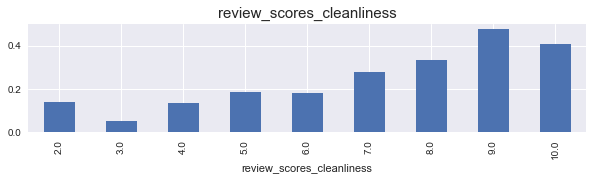

In [101]:
success_rate('review_scores_cleanliness')

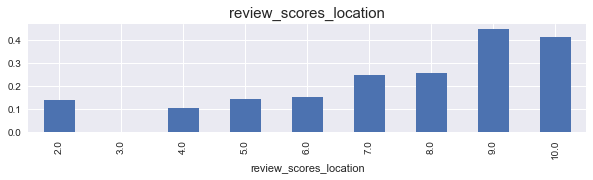

In [102]:
success_rate('review_scores_location')

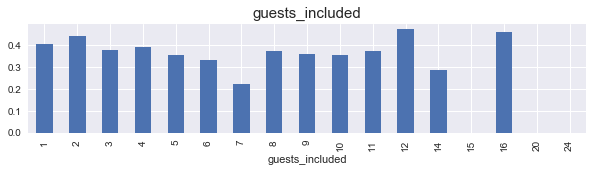

In [103]:
success_rate('guests_included')

Top 3 Negative coefficient features:

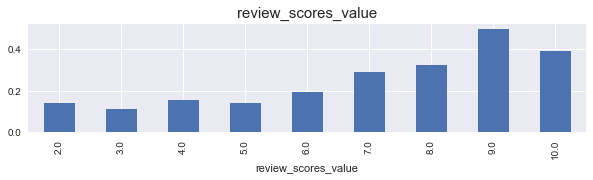

In [104]:
success_rate('review_scores_value')

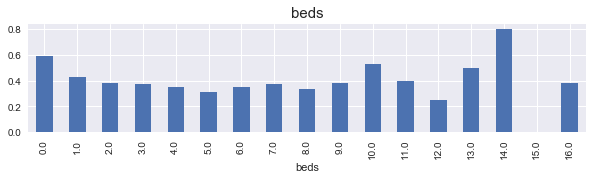

In [105]:
success_rate('beds')

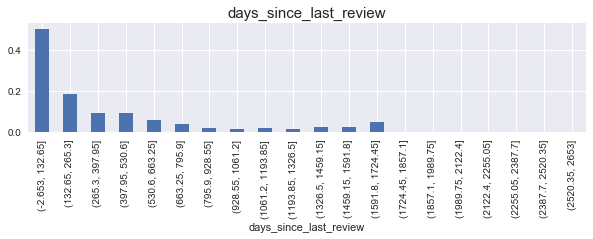

In [106]:
success_rate('days_since_last_review')

In general, as features with positive coefficient increase, success rate increases (converse for negative coefficient features) - confirms model coefficient assignments

### Random Forest Model
Ensemble method on decision trees, combining predictions from multiple trees (using bagging) to make more accurate predictions than individual models (and guard against overfitting).

Train model on entire feature space (minus number of reviews as before)

             precision    recall  f1-score   support

          0       0.84      0.87      0.85     14215
          1       0.80      0.76      0.78      9827

avg / total       0.82      0.82      0.82     24042

Confusion matrix, without normalization
[[12300  1915]
 [ 2331  7496]]


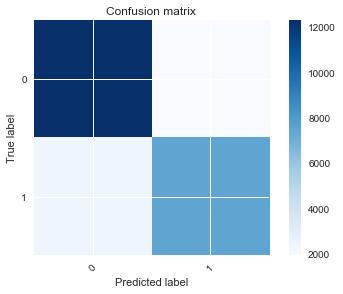

In [107]:
#prepare features and target - remove number of reviews and reviews per month for reasons explored earlier
X = listings.drop(['revenue_var','number_of_reviews','reviews_per_month'],axis=1)
y = (listings['revenue_var']>0)*1 

#get train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=101)

#create model based on 50 trees and with class_weight='balanced' (to deal with class imbalance observed earlier)
rfc = RandomForestClassifier(n_estimators=50,class_weight='balanced')

#train model and make predictions on test set
rfc.fit(X_train,y_train)
rfc_predictions = rfc.predict(X_test)

#evaluate predictive performance with classification report and confusion matrix
print(classification_report(y_test,rfc_predictions))

plot_confusion_matrix(
    cm=confusion_matrix(y_test,rfc_predictions),
    classes=sorted(list(y.unique()))
)

Better performance than logistic regression - fits irregular shape of data better as non-parametric

**Feature Importances**  
Measure of importance of feature in improving model's ability to discriminate between class values (hence improving prediction accuracy).

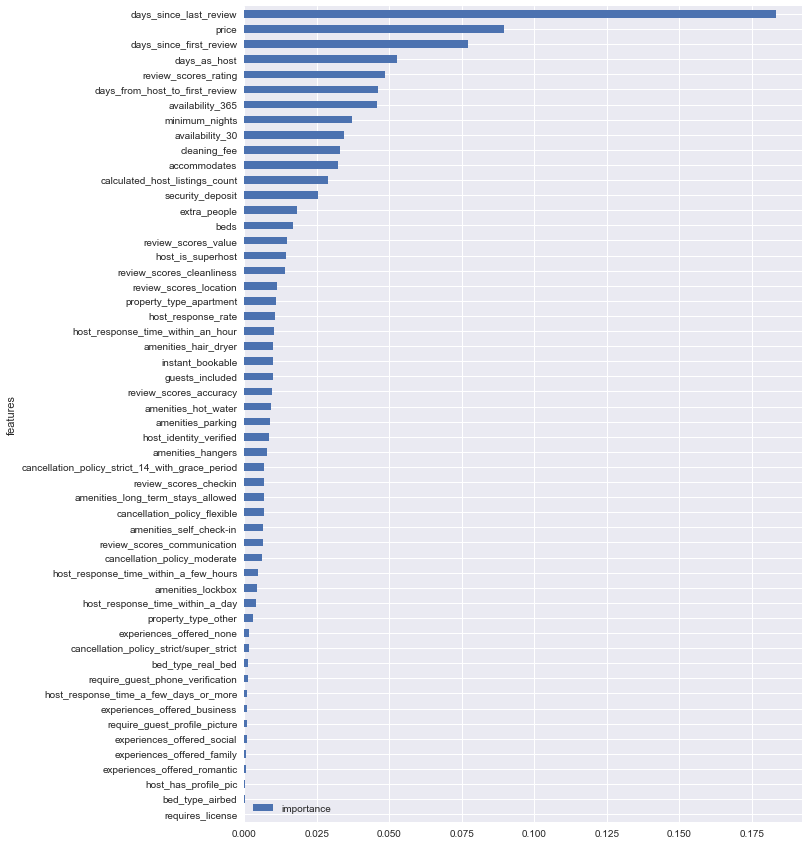

In [108]:
#plot feature importances in model
feature_imp = pd.DataFrame(list(X_train.columns),columns=['features'])
feature_imp['importance'] = pd.DataFrame(list(rfc.feature_importances_),columns=['importance'])
feature_imp['importance'] = feature_imp['importance'].apply(lambda x: float(format(x, 'f')))
feature_imp.sort_values(by='importance',ascending=True).plot(x='features',y='importance',kind='barh',figsize=(10,15))

Explore top 5 features to check for discriminative power

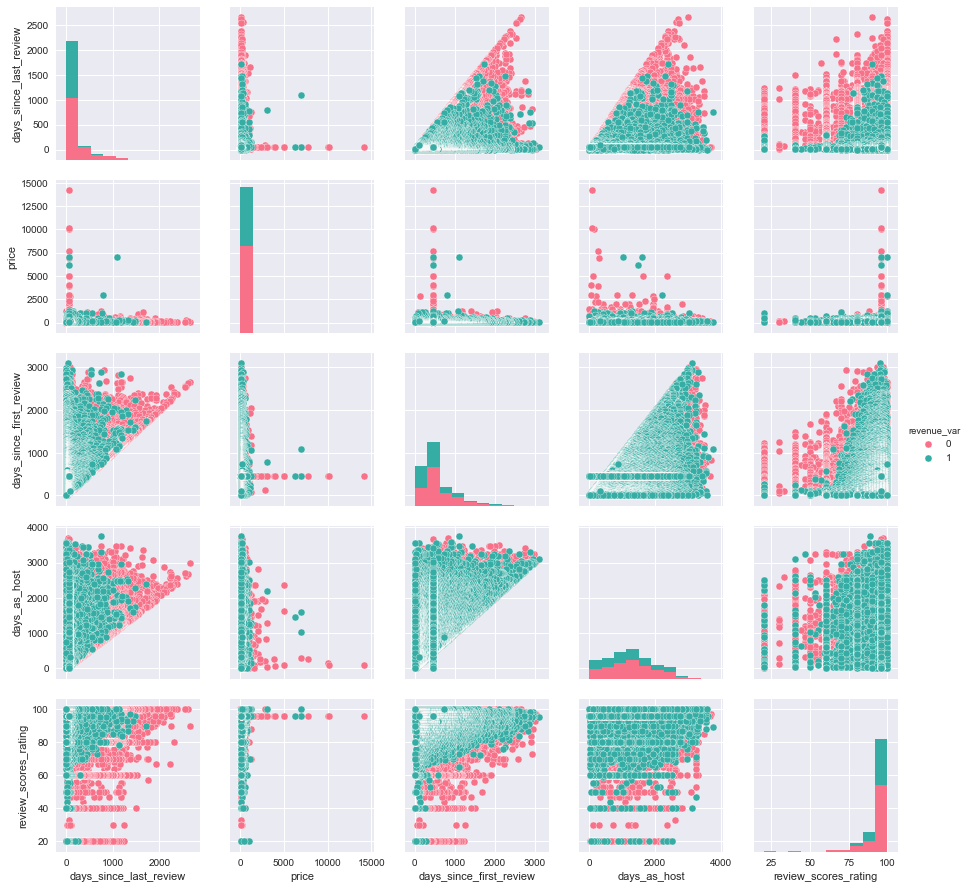

In [109]:
rfc_top_feats = ['days_since_last_review','price','days_since_first_review','days_as_host','review_scores_rating']
rfc_top_feats_df = listings[rfc_top_feats].join(target)
#rfc_top_feats_df.head()
sns.pairplot(data=rfc_top_feats_df,palette='husl',hue='revenue_var',\
    x_vars=rfc_top_feats,y_vars=rfc_top_feats)

Quite discriminative of target.

Irregular distribution detected in price feature - investigate:

In [110]:
#get value of days since first review, which these outliers remain constant along
is_outlier = (listings['price']>8000)
listings[is_outlier]['days_since_first_review'].head()

59021    459.0
69562    459.0
69563    459.0
Name: days_since_first_review, dtype: float64

In [111]:
#view sample of these points for all review related features
is_outlier = ((listings['price']>2000) & (listings['days_since_first_review']==459))
print('outlier count:',(is_outlier*1).sum())
listings[is_outlier][['days_since_first_review','days_since_last_review','reviews_per_month']].head().T

outlier count: 20


770     4547    21504   22048   48551
days_since_first_review  459.00  459.00  459.00  459.00  459.00
days_since_last_review    55.00   55.00   55.00   55.00   55.00
reviews_per_month          0.75    0.75    0.75    0.75    0.75

In [112]:
#same number of reviews per month, first and last reviews occurred together - reviews look computer generated/dummy
#remove these data points.
listings = listings[is_outlier==False].reset_index(drop=True)
target = (listings['revenue_var']>0)*1 

Several features above important for 3rd principal component. As before, let's simplify model inputs using PCA results.

Retrain model on features important for first 3 components

explained variance:  0.3727990096 

feature count:  20 

['accommodates', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_value', 'availability_365', 'review_scores_accuracy', 'days_from_host_to_first_review', 'days_since_last_review', 'cleaning_fee', 'guests_included', 'days_since_first_review', 'calculated_host_listings_count', 'review_scores_location', 'review_scores_checkin', 'review_scores_rating', 'availability_30', 'price', 'days_as_host', 'beds', 'security_deposit'] 

             precision    recall  f1-score   support

          0       0.83      0.85      0.84     14240
          1       0.77      0.75      0.76      9795

avg / total       0.81      0.81      0.81     24035

Confusion matrix, without normalization
[[12102  2138]
 [ 2494  7301]]


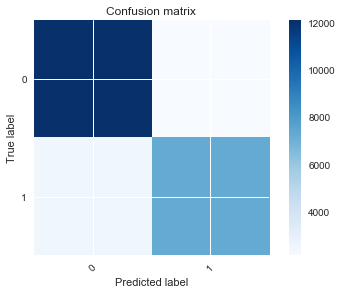

In [113]:
#pick most important features across first 3 principal components of feature space
X = listings[pca_important_feats(3,0.15)]
y = (listings['revenue_var']>0)*1 

#get train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=101)

#create model based on 50 trees and with class_weight='balanced' (to deal with class imbalance observed earlier)
rfc = RandomForestClassifier(n_estimators=50,class_weight='balanced')

#train model and make predictions on test set
rfc.fit(X_train,y_train)
rfc_predictions = rfc.predict(X_test)

#evaluate predictive performance with classification report and confusion matrix
print(classification_report(y_test,rfc_predictions))

plot_confusion_matrix(
    cm=confusion_matrix(y_test,rfc_predictions),
    classes=sorted(list(y.unique()))
)

Almost on par with original performance. Retrain on features important for first 4 components:

explained variance:  0.439551070155 

feature count:  22 

['review_scores_accuracy', 'days_from_host_to_first_review', 'review_scores_rating', 'security_deposit', 'price', 'host_response_rate', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_value', 'review_scores_checkin', 'beds', 'extra_people', 'days_since_last_review', 'availability_365', 'days_as_host', 'accommodates', 'cleaning_fee', 'guests_included', 'review_scores_location', 'calculated_host_listings_count', 'availability_30', 'days_since_first_review'] 

             precision    recall  f1-score   support

          0       0.83      0.85      0.84     14240
          1       0.78      0.74      0.76      9795

avg / total       0.81      0.81      0.81     24035

Confusion matrix, without normalization
[[12151  2089]
 [ 2521  7274]]


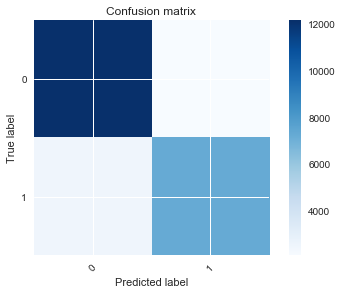

In [114]:
#pca most important features
important_feats = pca_important_feats(4,0.15)

#prepare features and target
X = listings[important_feats].copy()
y = (listings['revenue_var']>0)*1 

#get train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=101)

#initialise and train model, and make predictions on test set
rfc = RandomForestClassifier(n_estimators=50,class_weight='balanced')
rfc.fit(X_train,y_train)
rfc_predictions = rfc.predict(X_test)

#evaluate predictive performance with classification report and confusion matrix
print(classification_report(y_test,rfc_predictions))

plot_confusion_matrix(
    cm=confusion_matrix(y_test,rfc_predictions),
    classes=sorted(list(y.unique()))
)

No performance gain observed. Retrain on features important for first 6 components:

explained variance:  0.544563887138 

feature count:  23 

['review_scores_accuracy', 'days_from_host_to_first_review', 'review_scores_rating', 'security_deposit', 'price', 'host_response_rate', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_value', 'review_scores_checkin', 'beds', 'extra_people', 'days_since_last_review', 'availability_365', 'days_as_host', 'minimum_nights', 'accommodates', 'cleaning_fee', 'guests_included', 'review_scores_location', 'calculated_host_listings_count', 'availability_30', 'days_since_first_review'] 

             precision    recall  f1-score   support

          0       0.84      0.86      0.85     14240
          1       0.78      0.76      0.77      9795

avg / total       0.81      0.82      0.81     24035

Confusion matrix, without normalization
[[12189  2051]
 [ 2386  7409]]


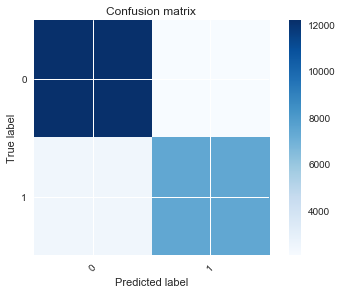

In [115]:
#pca most important features
important_feats = pca_important_feats(6,0.15)

#prepare features and target
X = listings[important_feats].copy()
y = (listings['revenue_var']>0)*1 

#get train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=101)

#initialise and train model, and make predictions on test set
rfc = RandomForestClassifier(n_estimators=50,class_weight='balanced')
rfc.fit(X_train,y_train)
rfc_predictions = rfc.predict(X_test)

#evaluate predictive performance with classification report and confusion matrix
print(classification_report(y_test,rfc_predictions))

plot_confusion_matrix(
    cm=confusion_matrix(y_test,rfc_predictions),
    classes=sorted(list(y.unique()))
)

On par with original performance. Retrain on first 22 principal components (to check if key information has been missed out)

explained variance:  0.901203340314 

feature count:  34 

['amenities_hot_water', 'review_scores_accuracy', 'days_from_host_to_first_review', 'cancellation_policy_strict_14_with_grace_period', 'review_scores_rating', 'security_deposit', 'price', 'amenities_parking', 'amenities_long_term_stays_allowed', 'host_response_rate', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_value', 'instant_bookable', 'property_type_apartment', 'review_scores_checkin', 'amenities_hair_dryer', 'beds', 'amenities_hangers', 'extra_people', 'days_since_last_review', 'cancellation_policy_flexible', 'host_response_time_within_an_hour', 'availability_365', 'days_as_host', 'minimum_nights', 'accommodates', 'cancellation_policy_moderate', 'cleaning_fee', 'guests_included', 'review_scores_location', 'calculated_host_listings_count', 'availability_30', 'days_since_first_review'] 

             precision    recall  f1-score   support

          0       0.84      0.86      0.85     14240
  

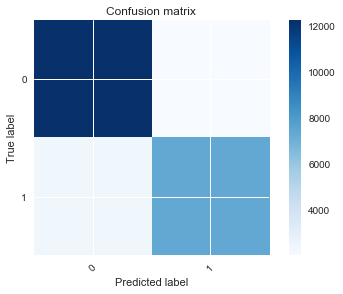

In [116]:
#pca most important features
important_feats = pca_important_feats(22,0.15)

#prepare features and target
X = listings[important_feats].copy()
y = (listings['revenue_var']>0)*1 

#get train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=101)

#initialise and train model, and make predictions on test set
rfc = RandomForestClassifier(n_estimators=50,class_weight='balanced')
rfc.fit(X_train,y_train)
rfc_predictions = rfc.predict(X_test)

#evaluate predictive performance with classification report and confusion matrix
print(classification_report(y_test,rfc_predictions))

plot_confusion_matrix(
    cm=confusion_matrix(y_test,rfc_predictions),
    classes=sorted(list(y.unique()))
)

No performance gain - sweet spot reached.

**K Fold Cross Validation**  
Use to decide on best number of features for model.

20 features:

In [117]:
important_feats = pca_important_feats(3,0.15,print_messages=0)

#set feature set to be equal to these features
X = listings[important_feats].copy()

#perform 10 fold cross validation
rfc = RandomForestClassifier(n_estimators=50,class_weight='balanced')
scores = cross_val_score(rfc,X,y,cv=10)

#print results of cross validation
print('accuracy score for each run: ',scores,'\n')
print('average accuracy overall: ',scores.mean(),'\n')
print('accuracy variance: ',scores.var(),'\n')

accuracy score for each run:  [ 0.68053267  0.77992861  0.75027457  0.7339374   0.70767541  0.70012358
  0.74035425  0.76712893  0.77262117  0.8109036 ] 

average accuracy overall:  0.74434801909 

accuracy variance:  0.00145465000086 



22 features:

In [118]:
important_feats = pca_important_feats(4,0.15,print_messages=0)

#set feature set to be equal to these features
X = listings[important_feats].copy()

#perform 10 fold cross validation
rfc = RandomForestClassifier(n_estimators=50,class_weight='balanced')
scores = cross_val_score(rfc,X,y,cv=10)

#print results of cross validation
print('accuracy score for each run: ',scores,'\n')
print('average accuracy overall: ',scores.mean(),'\n')
print('accuracy variance: ',scores.var(),'\n')

accuracy score for each run:  [ 0.68121911  0.77841845  0.75974739  0.73489841  0.71989565  0.70643965
  0.73939311  0.77248387  0.77138542  0.80692118] 

average accuracy overall:  0.747080222955 

accuracy variance:  0.00128954004625 



23 features:

In [119]:
important_feats = pca_important_feats(6,0.15,print_messages=0)

#set feature set to be equal to these features
X = listings[important_feats].copy()

#perform 10 fold cross validation
rfc = RandomForestClassifier(n_estimators=50,class_weight='balanced')
scores = cross_val_score(rfc,X,y,cv=10)

#print results of cross validation
print('accuracy score for each run: ',scores,'\n')
print('average accuracy overall: ',scores.mean(),'\n')
print('accuracy variance: ',scores.var(),'\n')

accuracy score for each run:  [ 0.69549698  0.79557935  0.77745744  0.75562878  0.7370589   0.73088013
  0.7595771   0.78154607  0.77234656  0.80856907] 

average accuracy overall:  0.761414038261 

accuracy variance:  0.00100804696834 



23 features best - higher accuracy, lower variance

Explore feature importance for this model.

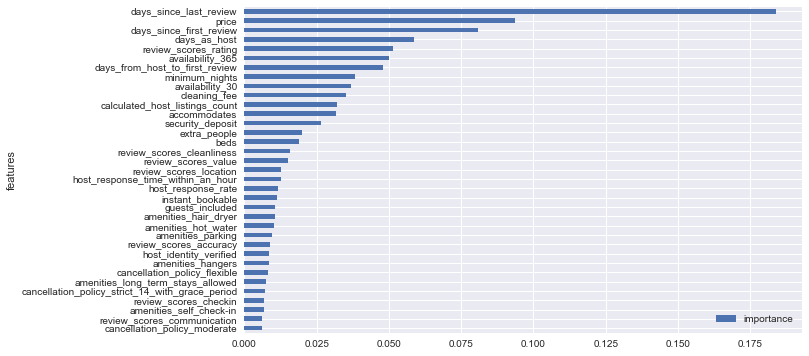

In [120]:
#pca most important features
important_feats = pca_important_feats(6,0.05,print_messages=0)

#prepare features and target
X = listings[important_feats].copy()
y = (listings['revenue_var']>0)*1 

#get train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=101)

#initialise and train model, and make predictions on test set
rfc = RandomForestClassifier(n_estimators=50,class_weight='balanced')
rfc.fit(X_train,y_train)
rfc_predictions = rfc.predict(X_test)

#plot feature importances in model
feature_imp = pd.DataFrame(list(X_train.columns),columns=['features'])
feature_imp['importance'] = pd.DataFrame(list(rfc.feature_importances_),columns=['importance'])
feature_imp['importance'] = feature_imp['importance'].apply(lambda x: float(format(x, 'f')))
feature_imp.sort_values(by='importance',ascending=True).plot(x='features',y='importance',kind='barh',figsize=(10,6))

Explore top features:

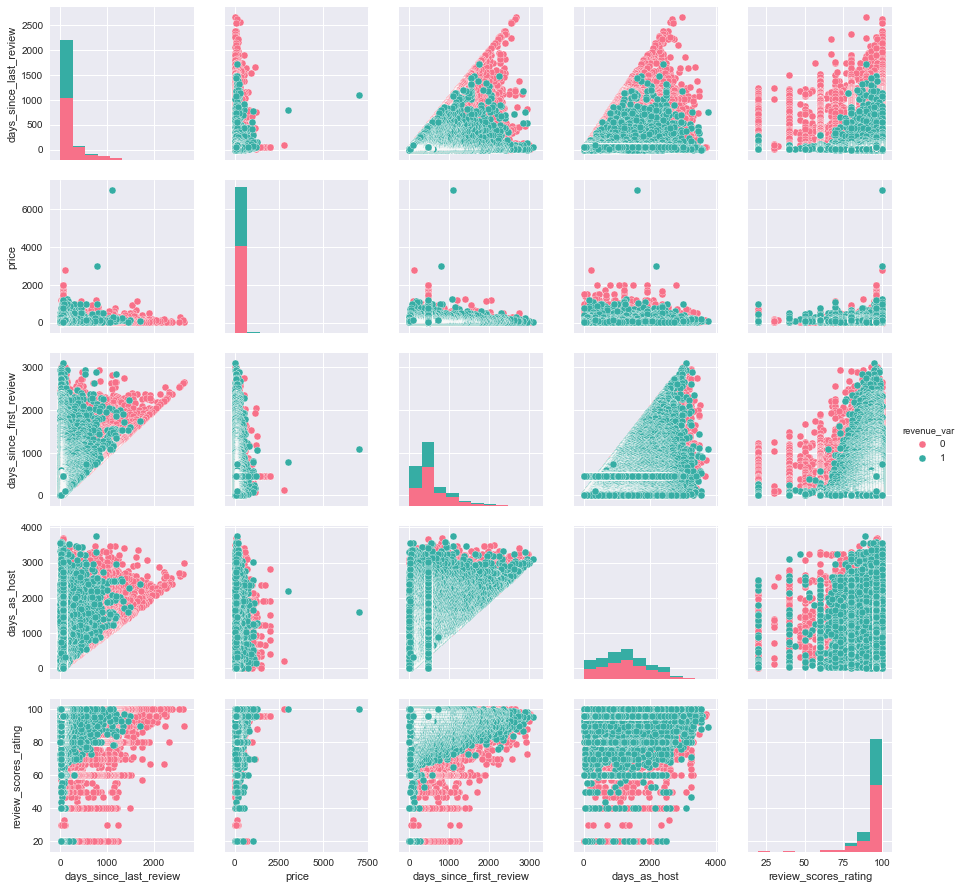

In [121]:
rfc_top_feats = \
list(feature_imp.sort_values(by='importance',ascending=False).reset_index(drop=True).loc[:4,'features'])
rfc_top_feats_df = listings[rfc_top_feats].join(target)

sns.pairplot(data=rfc_top_feats_df,palette='husl',hue='revenue_var',\
    x_vars=rfc_top_feats,y_vars=rfc_top_feats)